## 0. Install on Linux

Run these commands in the terminal:
```bash
    cd /home/gxj/Desktop/gxj
    git clone https://github.com/dattalab/keypoint-moseq.@v0.6.3
    cd keypoint-moseq
    conda activate keypoint_moseq
    pip install -e .
```

For more infomation , see: [GitHub](https://github.com/dattalab/keypoint-moseq) and [Tutorial](https://keypoint-moseq.readthedocs.io/en/latest/index.html).

### 0.0 Set up GPU device and import `keypoint_moseq`.

<mark>TODO: Multi-GPU AssertionError<mark>
[Issues#236](https://github.com/dattalab/keypoint-moseq/issues/236)

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
import keypoint_moseq as kpms
import jax
import jax_moseq
jax_moseq.utils.set_mixed_map_gpus(1)  # you can only use one gpu.
jax_moseq.utils.set_mixed_map_iters(10)  # More iters -> less memory required
print(jax.devices())
print(jax.device_count())
print(jax_moseq.utils.get_mixed_map_iters())

[CudaDevice(id=0)]
1
10


## 1. Project Setup.

### 1.1 Edit the config file.

Run:

```python
    import keypoint_moseq as kpms

    kpms.setup_project(project_dir)
```

Then you will find a default `config.yml` file, modify it. You can not use `dannce_config` because the `Label3D` used is not by the original author, but by Chen Xinfeng. The structure of skeleton config file `mouse_21.mat` is modified.

Or you can setup project with this:

```python
    kpms.setup_project(project_dir, video_dir=video_dir, bodyparts=bodyparts, skeleton=skeleton)
```

The config can be edited in a text editor or using the function `kpms.update_config`, as shown below. In general, the following parameters should be specified for each project:

 - `bodyparts` (name of each keypoint; automatically imported from SLEAP/DeepLabCut)

 - `use_bodyparts` (subset of bodyparts to use for modeling, set to all bodyparts by default; for mice we recommend excluding the tail)

 - `anterior_bodyparts` and `posterior_bodyparts` (used for rotational alignment)

 - `video_dir` (directory with videos of each experiment)

 - `fps` (frame per second of the input video)

### 1.2 Load data.

#### 1.2.1 load configuration.

Note that here, 'config' is imported as a lambda function, so you can call it with `config()` to get the current configuration.

In [2]:
import numpy as np

project_dir = "/home/gxj/Desktop/gxj/kpms_project"
config_file = f"{project_dir}/config.yml"
config = lambda: kpms.load_config(project_dir)
validity = kpms.check_config_validity(config())
print(f"Config validity: {validity}")

Config validity: True


#### 1.2.2 load all Dannce data.

All sessions data files are named `save_data_AVG0.mat` and stored in different subfolders. So you need to set `path_in_name=True`.

If you need to load 2D `DeepLabCut` data, change `format` to `"deeplabcut"`.

In [ ]:
import os
import copy

sess_dir = "/home/gxj/Desktop/Synology25/dannce_results"
all_sessions = sorted([
    os.path.join(sess_dir, d)
    for d in os.listdir(sess_dir)
    if os.path.isdir(os.path.join(sess_dir, d))
])
keypoint_data_path = all_sessions[-5:] # Exclude last 5 sessions for multi-GPU testing.
all_files = kpms.io.list_files_with_exts(keypoint_data_path, [".mat"], recursive=True)
dannce_files = [f for f in all_files if "save_data_AVG0" in os.path.basename(f)]  # Exlude com files.
# print(dannce_files)
coordinates, confidences, bodyparts = kpms.load_keypoints(dannce_files, format="dannce", path_in_name=True)

raw_coordinates = copy.deepcopy(coordinates)
raw_confidences = copy.deepcopy(confidences)

Loading keypoints: 100%|██████████████| 205/205 [00:30<00:00,  6.65it/s]


### 1.3 Remove outlier keypoints. 

Removing large outliers can improve the robustness of model fitting. A common type of outlier is a keypoint which briefly moves very far away from the animal as the result of a tracking error. The following cell classifies keypoints as outliers based on their distance to the animal’s medoid. The outlier keypoints are then interpolated and their confidences are set to 0 so that they are interpolated for modeling as well.

 - Use `outlier_scale_factor` to adjust the stringency of outlier detection (higher values -> more stringent)

 - Plots showing distance to medoid before and after outlier interpolation are saved to `{project_dir}/quality_assurance/plots/`

 - Plotting can take a few minutes, so by default plots will not be regenerated when re-running this cell. To experiment with the effects of setting different values for outlier_scale_factor, set `overwrite=True` in outlier_removal.

There is no `kpms.outlier_removal` function in v0.6.3 but you can use code below to remove outliers. And `DataProcessor.find_RULE_outliers` is defined by myself. It is composed of three methods: `find_vectorized_speed_outliers`, `find_angle_outliers`, and `find_displacement_outliers`.

In [5]:
from analyze_data_3d_utils import DataProcessor
import yaml
import pickle

with open("analyze_data_3d_cfg.yaml", "r") as f:
    cfg = yaml.safe_load(f)

fps = cfg["fps"]
joint_names = cfg["joint_names"]
limb_orders = cfg["limb_orders"]
joint_creds = cfg["joint_creds"]
skel_conns = [tuple(pair) for pair in cfg["skel_conns"]]  # convert to tuples.


for recording_name in coordinates:
    raw_coords = coordinates[recording_name].copy()
    outliers = kpms.find_medoid_distance_outliers(raw_coords, **config())  # Use Median Absolute Deviation.
    outliers_ = DataProcessor.find_RULE_outliers(
        raw_coords, joint_names, limb_orders, skel_conns, joint_creds, 
        prev_outliers=outliers, outlier_scale_factors={'velocity': 5, 'angle': 5, 'displacement': 5})
    coordinates[recording_name] = kpms.interpolate_keypoints(raw_coords, outliers_["mask"])  # linear interpolation
    confidences[recording_name] = np.where(outliers_["mask"], 0, confidences[recording_name])
    kpms.plot_medoid_distance_outliers(
        project_dir,
        recording_name,
        raw_coords,
        coordinates[recording_name],
        outliers["mask"],
        outliers["thresholds"],
        joint_names
    )
    
with open(f'{project_dir}/kpms_train_data.pkl', 'wb') as f:
    pickle.dump({'coordinates': coordinates, 'confidences': confidences}, f)

Saved keypoint distance outlier plot for -home-gxj-Desktop-Synology25-dannce_results-exp_111-save_data_AVG0 to /home/gxj/Desktop/gxj/kpms_project/quality_assurance/plots/keypoint_distance_outliers/-home-gxj-Desktop-Synology25-dannce_results-exp_111-save_data_AVG0.png.
Saved keypoint distance outlier plot for -home-gxj-Desktop-Synology25-dannce_results-exp_112-save_data_AVG0 to /home/gxj/Desktop/gxj/kpms_project/quality_assurance/plots/keypoint_distance_outliers/-home-gxj-Desktop-Synology25-dannce_results-exp_112-save_data_AVG0.png.
Saved keypoint distance outlier plot for -home-gxj-Desktop-Synology25-dannce_results-exp_113-save_data_AVG0 to /home/gxj/Desktop/gxj/kpms_project/quality_assurance/plots/keypoint_distance_outliers/-home-gxj-Desktop-Synology25-dannce_results-exp_113-save_data_AVG0.png.
Saved keypoint distance outlier plot for -home-gxj-Desktop-Synology25-dannce_results-exp_114-save_data_AVG0 to /home/gxj/Desktop/gxj/kpms_project/quality_assurance/plots/keypoint_distance_outli

### 1.4 Format data for modeling.

#### 1.4.1 Load saved data.

`kpms_data.pkl` is saved all sessions coordinates (60313, 21, 3) and confidences (60313, 21) after outlier removal. You need to downsample and simplify keypoints before fitting the model, as shown below.

In [3]:
import pickle

with open(f'{project_dir}/kpms_data.pkl', 'rb') as f:
    kpms_data = pickle.load(f)  # correceted coordinates and confidences.

coordinates = kpms_data['coordinates']
confidences = kpms_data['confidences']
print(len(coordinates))
print(confidences[list(confidences.keys())[0]].shape)
print(coordinates[list(coordinates.keys())[0]].shape)

205
(60313, 21)
(60313, 21, 3)


#### 1.4.2 Get train dataset.

There are 205 sessions and over 12,300,000 frames in total. But only 80 GB RAM is available on the labserver. So we need to sample frames from all sessions to form a training dataset. 102,500 frames or 500 frames per session takes about 80 GB RAM when `set_mixed_map_iter(1)`.

In [4]:
def get_frames_mask(coordinates, n_frames=500, mode="random", start=None, seed=None):
    """
    Get frames mask for sampling keypoints.
    """
    if seed is not None:
        np.random.seed(seed)
    frames_mask_dict = {}
    for session, coords in coordinates.items():
        total_frames, n_joint = coords.shape[:2]
        mask = np.zeros((total_frames, n_joint), dtype=bool)
        if mode == "random":
            n = min(n_frames, total_frames)
            max_start = max(0, total_frames - n)
            s = np.random.randint(0, max_start + 1)
            e = s + n
            idx = np.arange(s, e)
        elif mode == "range":
            s = start if start is not None else 0
            e = min(s+n_frames, total_frames)
            idx = np.arange(s, e)
        else:
            raise ValueError("mode must be 'random' or 'range'")
        mask[idx, :] = True
        frames_mask_dict[session] = mask

    return frames_mask_dict

def downsample_keypoints(coordinates, confidences, frames_mask):
    """
    Sample keypoints based on frames mask.
    """
    sampled_coords = {}
    sampled_confs = {}
    for session, mask in frames_mask.items():
        coords = coordinates[session]
        confs = confidences[session]
        idx = np.any(mask, axis=1).nonzero()[0]
        coords_selected = coords[idx]
        confs_selected = confs[idx] 
        sampled_coords[session] = coords_selected
        sampled_confs[session] = confs_selected
    return sampled_coords, sampled_confs

frames_mask = get_frames_mask(coordinates, n_frames=5000, mode="random", seed=42)
coordinates, confidences = downsample_keypoints(coordinates, confidences, frames_mask)
print(confidences[list(confidences.keys())[0]].shape)
print(coordinates[list(confidences.keys())[0]].shape)

(5000, 21)
(5000, 21, 3)


#### 1.4.3 Simplify keypoints by merging limbs keypoints.

In [5]:
import yaml
from analyze_data_3d_utils import DataProcessor

with open("analyze_data_3d_cfg.yaml", "r") as f:
    cfg = yaml.safe_load(f)

fps = cfg["fps"]
joint_names = cfg["joint_names"]
limb_combos = cfg["limb_combos"]
joint_creds = cfg["joint_creds"]
skel_conns = [tuple(pair) for pair in cfg["skel_conns"]]  # convert to tuples.

coordinates, simp_joint_names = DataProcessor.simplify_coord_dict(
    coordinates, joint_names, limb_combos
)
confidences, simp_joint_names = DataProcessor.simplify_coord_dict(
    confidences, joint_names, limb_combos
)
print(confidences[list(confidences.keys())[0]].shape)
print(coordinates[list(confidences.keys())[0]].shape)


(5000, 15)
(5000, 15, 3)


In [9]:
np.where(frames_mask['-home-gxj-Desktop-Synology25-dannce_results-exp_213-save_data_AVG0'])[0]

array([1267, 1267, 1267, ..., 6266, 6266, 6266])

#### 1.4.4 Format data.

In [6]:
data, metadata = kpms.format_data(coordinates, confidences, **config())

### 1.5 Calibration.

3D data is not support for calibaration. For more details, see:[Calibration](https://keypoint-moseq.readthedocs.io/en/latest/modeling.html#calibration).

### 1.6 Fit PCA.

Run the cell below to fit a PCA model to aligned and centered keypoint coordinates.

 - The model is saved to `{project_dir}/pca.p` and can be reloaded using `kpms.load_pca`.

 - Two plots are generated: a cumulative scree plot and a depiction of each PC, where translucent nodes/edges represent the mean pose and opaque nodes/edges represent a perturbation in the direction of the PC.

 - After fitting, edit `latent_dimension` in the config. This determines the dimension of the pose trajectory used to fit keypoint-MoSeq. A good heuristic is the number of dimensions needed to explain 90% of variance, or 10 dimensions - whichever is lower. (Author's data is 8 keypoints.)

We use 14 keypoints and 24 dimensions in this project. And the number of PCs is $ (14 - 1) * 3 = 39 $.

>=90.0% of variance exlained by 24 components.


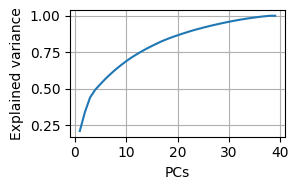

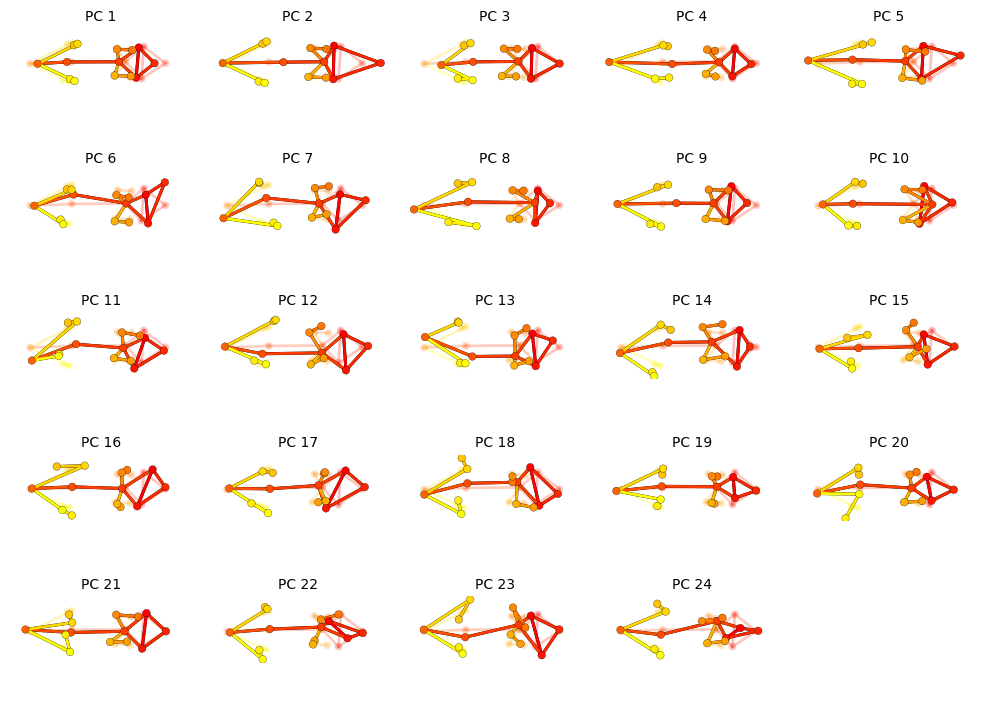

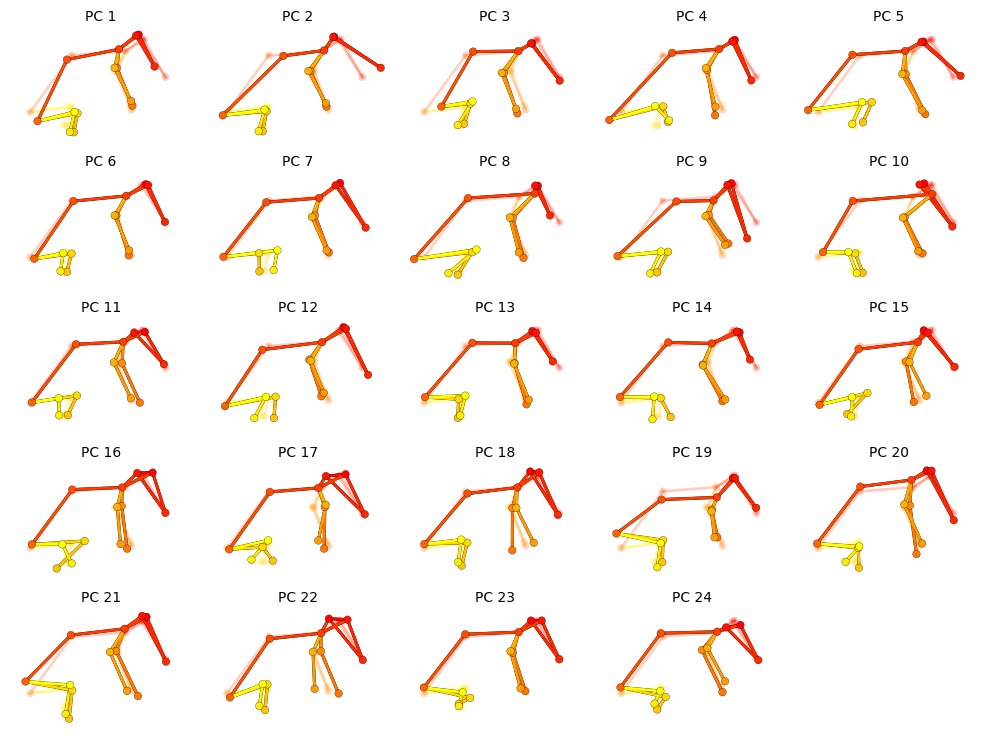

Saved interactive plot to /home/gxj/Desktop/gxj/kpms_project/pcs.html


In [7]:
pca = kpms.fit_pca(**data, **config())
kpms.save_pca(pca, project_dir)

kpms.print_dims_to_explain_variance(pca, 0.90)
kpms.plot_scree(pca, project_dir=project_dir)
kpms.plot_pcs(pca, project_dir=project_dir, plot_n_pcs=24, **config());


## 2. Model training.

Fitting a keypoint-MoSeq model involves:

1. **Estimating hyperparameters**: Set model hyperparameters that can be automatically estimated from the input data.

2. **Initialization**: Auto-regressive (AR) parameters and syllable sequences are randomly initialized using pose trajectories from PCA.

3. **Fitting an AR-HMM**: The AR parameters, transition probabilities and syllable sequences are iteratively updated through Gibbs sampling.

4. **Fitting the full model**: All parameters, including both the AR-HMM as well as centroid, heading, noise-estimates and continuous latent states (i.e. pose trajectories) are iteratively updated through Gibbs sampling. This step is especially useful for noisy data.

5. **Extracting model results**: The learned states of the model are parsed and saved to disk for vizualization and downstream analysis.

6. **[Optional] Applying the trained model**: The learned model parameters can be used to infer a syllable sequences for additional data.

### 2.1 Setting kappa.

Most users will need to adjust the `kappa` hyperparameter to achieve the desired distribution of syllable durations. For this tutorial we chose kappa values that yielded a median syllable duration of 400ms (12 frames). Most users will need to tune kappa to their particular dataset. Higher values of kappa lead to longer syllables. **You will need to pick two kappas: one for AR-HMM fitting and one for the full model.**

 - We recommend iteratively updating kappa and refitting the model until the target syllable time-scale is attained.

 - Model fitting can be stopped at any time by interrupting the kernel, and then restarted with a new kappa value.

 - The full model will generally require a lower value of kappa to yield the same target syllable durations.

 - To adjust the value of kappa in the model, use `kpms.update_hypparams` as shown below. Note that this command only changes kappa in the model dictionary, not the kappa value in the config file. The value in the config is only used during model initialization.

Cell below compares `kappa` hyperparameter, for our data, `kappa=1e6` leads to a median syllable duration of ~ 5 frames or 0.25 seconds.



=== Training with kappa=1e+04 ===
Outputs will be saved to
/home/gxj/Desktop/gxj/kpms_project/kappa_scan_1e+04


100%|███████████████████████████████████| 51/51 [00:56<00:00,  1.12s/it]


Outputs will be saved to
/home/gxj/Desktop/gxj/kpms_project/kappa_scan_1e+04


100%|███████████████████████████████| 401/401 [2:23:25<00:00, 21.46s/it]


Training completed in 8682.01s
Final median duration: 2.00 frames

=== Training with kappa=1e+05 ===
Outputs will be saved to
/home/gxj/Desktop/gxj/kpms_project/kappa_scan_1e+05


100%|███████████████████████████████████| 51/51 [00:49<00:00,  1.03it/s]


Outputs will be saved to
/home/gxj/Desktop/gxj/kpms_project/kappa_scan_1e+05


100%|███████████████████████████████| 401/401 [2:22:46<00:00, 21.36s/it]


Training completed in 8625.23s
Final median duration: 4.00 frames

=== Training with kappa=1e+06 ===
Outputs will be saved to
/home/gxj/Desktop/gxj/kpms_project/kappa_scan_1e+06


100%|███████████████████████████████████| 51/51 [00:50<00:00,  1.01it/s]


Outputs will be saved to
/home/gxj/Desktop/gxj/kpms_project/kappa_scan_1e+06


100%|███████████████████████████████| 401/401 [2:22:40<00:00, 21.35s/it]


Training completed in 8616.12s
Final median duration: 7.00 frames

=== Training with kappa=1e+07 ===
Outputs will be saved to
/home/gxj/Desktop/gxj/kpms_project/kappa_scan_1e+07


100%|███████████████████████████████████| 51/51 [00:49<00:00,  1.02it/s]


Outputs will be saved to
/home/gxj/Desktop/gxj/kpms_project/kappa_scan_1e+07


100%|███████████████████████████████| 401/401 [2:22:46<00:00, 21.36s/it]


Training completed in 8630.13s
Final median duration: 9.00 frames

=== Training with kappa=1e+08 ===
Outputs will be saved to
/home/gxj/Desktop/gxj/kpms_project/kappa_scan_1e+08


100%|███████████████████████████████████| 51/51 [00:50<00:00,  1.01it/s]


Outputs will be saved to
/home/gxj/Desktop/gxj/kpms_project/kappa_scan_1e+08


100%|███████████████████████████████| 401/401 [2:22:47<00:00, 21.37s/it]


Training completed in 8622.24s
Final median duration: 12.00 frames

Plot saved to: /home/gxj/Desktop/gxj/kpms_project/kappa_comparison.png


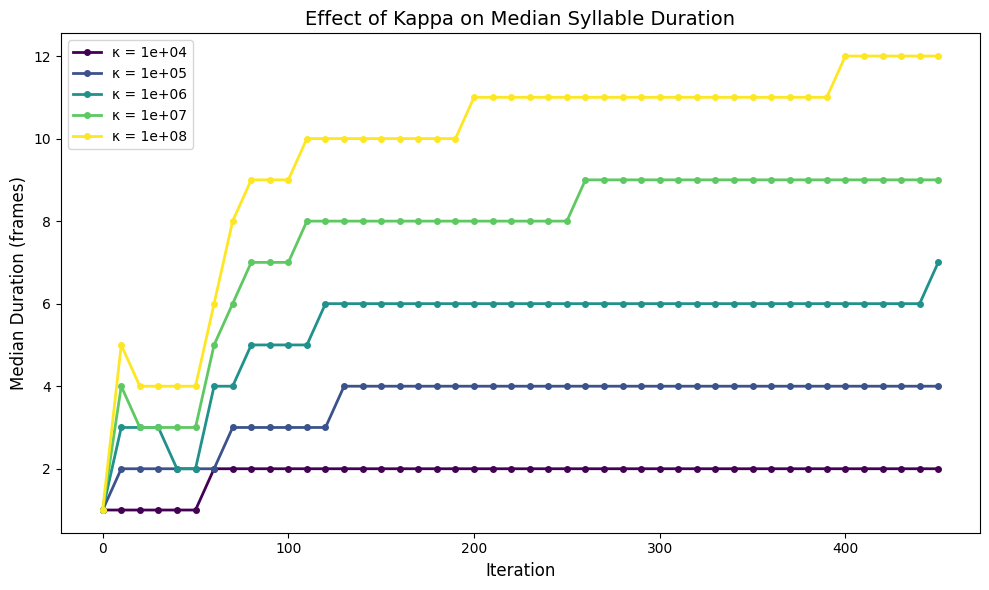

Results saved to: /home/gxj/Desktop/gxj/kpms_project/kappa_scan_results.csv

=== Final Statistics ===
κ = 1e+04: Final median duration = 2.00 frames
κ = 1e+05: Final median duration = 4.00 frames
κ = 1e+06: Final median duration = 7.00 frames
κ = 1e+07: Final median duration = 9.00 frames
κ = 1e+08: Final median duration = 12.00 frames


In [8]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
from jax_moseq.utils import get_durations

kappas = [1e4, 1e5, 1e6, 1e7, 1e8]  # tested kappa values

median_duration_histories = {}
for kappa in kappas:
    print(f"\n=== Training with kappa={kappa:.0e} ===")
    start = time.time()

    model_init = kpms.init_model(data, pca=pca, **config())
    model_init = kpms.update_hypparams(model_init, kappa=float(kappa))
    model_name = f'kappa_scan_{kappa:.0e}'
    # train AR-HMM first
    model, model_name = kpms.fit_model(
        model_init, data, metadata, project_dir, model_name,
        ar_only=True,
        num_iters=50,
        save_every_n_iters=10, 
        generate_progress_plots=False
    )
    # train full model
    model, model_name = kpms.fit_model(
        model, data, metadata, project_dir, model_name,
        ar_only=False,
        start_iter=50,
        num_iters=450,
        save_every_n_iters=10,
        generate_progress_plots=False
    )
    elapsed = time.time() - start
    
    print(f"Training completed in {elapsed:.2f}s")
    checkpoint_path = f"{project_dir}/{model_name}/checkpoint.h5"
    history = {}
    # Analyze median duration over iterations
    with h5py.File(checkpoint_path, "r") as h5:
        mask = h5["data/mask"][()]
        iterations = np.sort([int(i) for i in h5["model_snapshots"]])
        for itr in iterations:
            z = h5[f"model_snapshots/{itr}/states/z"][()]
            durs = get_durations(z, mask)
            history[itr] = np.median(durs)
    median_duration_histories[kappa] = history
    print(f"Final median duration: {history[iterations[-1]]:.2f} frames")
# Plotting results
fig, ax = plt.subplots(figsize=(10, 6))
for i, (kappa, history) in enumerate(median_duration_histories.items()):
    color = plt.cm.viridis(i / (len(kappas) - 1))
    iterations = sorted(history.keys())
    durations = [history[it] for it in iterations]
    ax.plot(iterations, durations, color=color, label=f'κ = {kappa:.0e}', 
            marker='o', markersize=4, linewidth=2)
ax.set_xlabel('Iteration', fontsize=12)
ax.set_ylabel('Median Duration (frames)', fontsize=12)
ax.set_title('Effect of Kappa on Median Syllable Duration', fontsize=14)
ax.legend(loc='best', fontsize=10)
plt.tight_layout()
save_path = f"{project_dir}/kappa_comparison.png"
plt.savefig(save_path, dpi=300)
print(f"\nPlot saved to: {save_path}")
plt.show()
# Save results to CSV
results_df = pd.DataFrame([
    {
    'kappa': kappa,
    'iteration': it,
    'median_duration': dur
    }
    for kappa, history in median_duration_histories.items()
    for it, dur in history.items()
])
results_df.to_csv(f"{project_dir}/kappa_scan_results.csv", index=False)
print(f"Results saved to: {project_dir}/kappa_scan_results.csv")
# Print final statistics
print("\n=== Final Statistics ===")
for kappa, history in median_duration_histories.items():
    final_iter = max(history.keys())
    final_duration = history[final_iter]
    print(f"κ = {kappa:.0e}: Final median duration = {final_duration:.2f} frames")

### 2.2 Estimating Hyperparameters.

We provide heuristics for adjusting a subset of model hyperparameters:

 - **sigmasq_loc**: The expected distance that the centroid will move each frame. If this is set too high, the centroid trajectory will be overly noisy. If it’s set too low, the centroid may deviate from the animal’s true location during fast locomotion. `estimate_sigmasq_loc` estimates this hyperparameter based on the empirical frame-to-frame movement of the filtered centroid trajectory.

In [20]:
kpms.update_config(
    project_dir,
    sigmasq_loc=kpms.estimate_sigmasq_loc(
        data["Y"], 
        data["mask"], 
        filter_size=config()["fps"]),
    latent_dim=24,   # change to desired latent dimension
    num_states=50  # change to desired number of states
    )

### 2.3 Initialization.

In [11]:
model = kpms.init_model(data, pca=pca, **config())  # initialize the model

### 2.4 Fitting an AR-HMM.

In addition to fitting an AR-HMM, the function below:

 - generates a name for the model and a corresponding directory in project_dir

 - saves a checkpoint every 25 iterations from which fitting can be restarted

 - plots the progress of fitting every 25 iterations, including

   - the distributions of syllable frequencies and durations for the most recent iteration

   - the change in median syllable duration across fitting iterations

   - a sample of the syllable sequence across iterations in a random window

**Note**: Some users have reported systematic differences in the way syllables are assigned when applying a model to new data. To control for this, we recommend running `apply_model` to both the new and original data and using these new results instead of the original model output. To save the original results, simply rename the original results.h5 file or save the new results to a different filename using `results_path="new_file_name.h5"`.

Outputs will be saved to /home/gxj/Desktop/gxj/kpms_project/simp_1e6ka
ppa_24dim_50states_5000f_42seeds


 20%|██████▊                            | 10/51 [00:16<00:43,  1.06s/it]

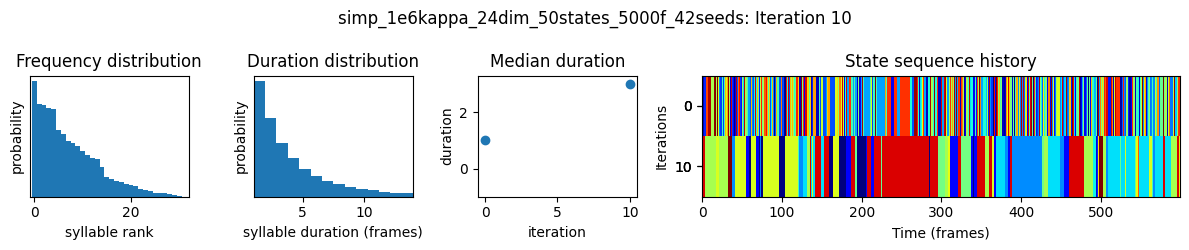

 39%|█████████████▋                     | 20/51 [00:27<00:30,  1.01it/s]

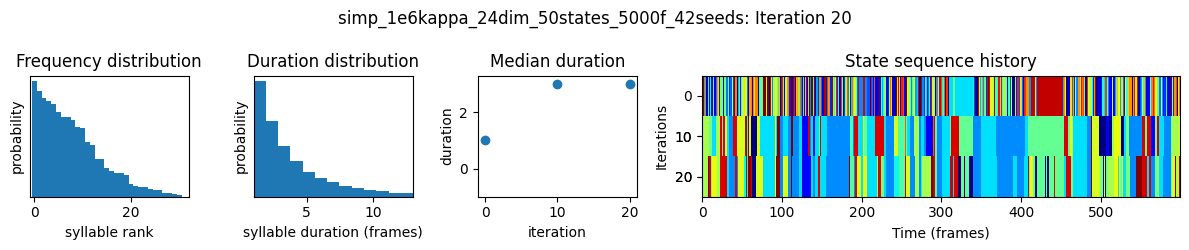

 59%|████████████████████▌              | 30/51 [00:37<00:20,  1.01it/s]

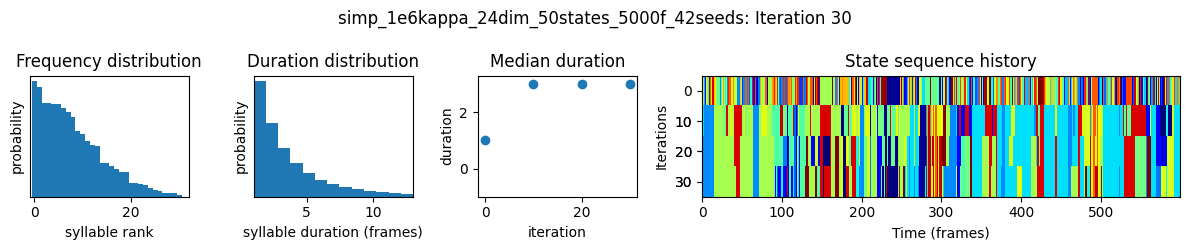

 78%|███████████████████████████▍       | 40/51 [00:48<00:10,  1.01it/s]

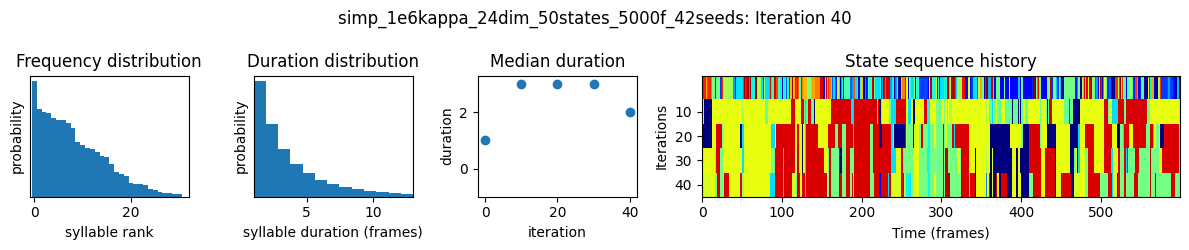

 98%|██████████████████████████████████▎| 50/51 [00:58<00:00,  1.01it/s]

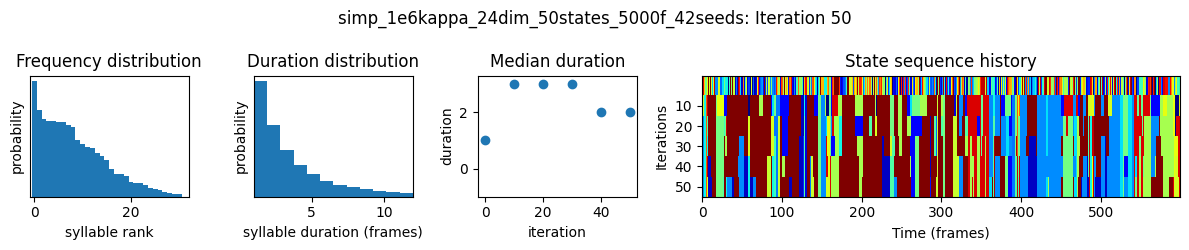

100%|███████████████████████████████████| 51/51 [01:00<00:00,  1.19s/it]


In [12]:
num_ar_iters = 50
model_name = 'simp_1e6kappa_24dim_50states_5000f_42seeds'
model = kpms.update_hypparams(model, kappa=1e6)  # optionally modify kappa

model, model_name = kpms.fit_model(
    model, 
    data, 
    metadata, 
    project_dir, 
    model_name, 
    ar_only=True, 
    num_iters=num_ar_iters, 
    save_every_n_iters=10
)

### 2.5 Fitting the full model.

The following code fits a full keypoint-MoSeq model using the results of AR-HMM fitting for initialization. If using your own data, you may need to try a few values of kappa at this step.

Example fitting process:

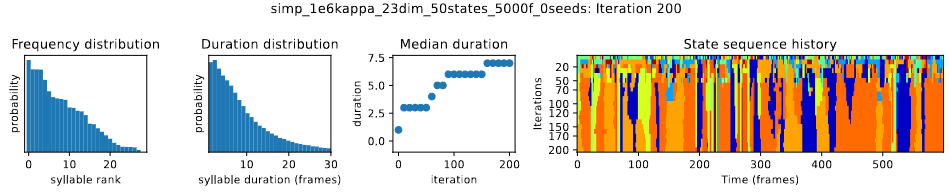

#### 2.5.1 Fitting the full model.

Outputs will be saved to /home/gxj/Desktop/gxj/kpms_project/simp_1e6ka
ppa_24dim_50states_5000f_42seeds


  4%|█▎                              | 10/251 [04:21<1:28:15, 21.97s/it]

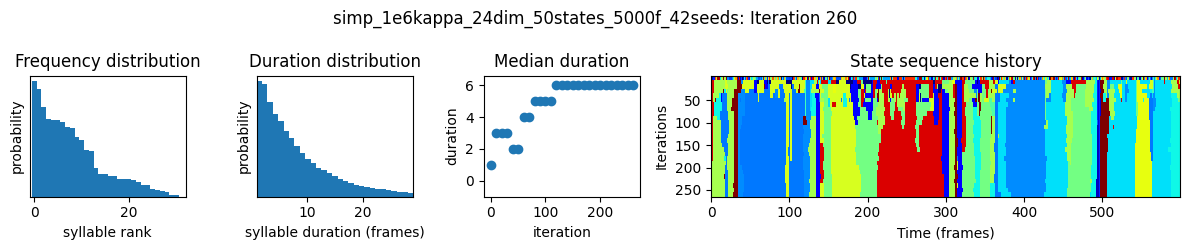

  8%|██▌                             | 20/251 [07:57<1:22:47, 21.50s/it]

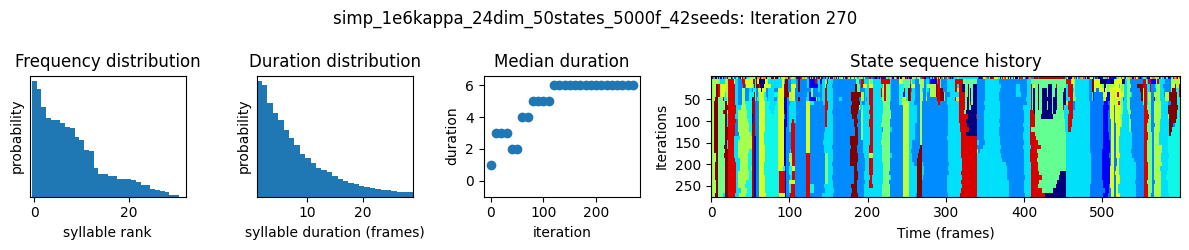

 12%|███▊                            | 30/251 [11:33<1:19:05, 21.47s/it]

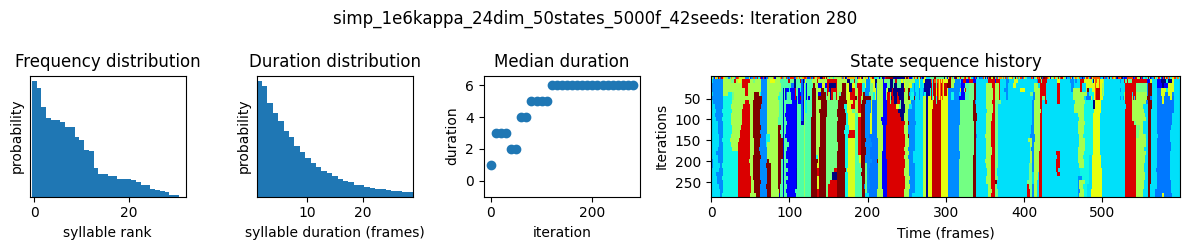

 16%|█████                           | 40/251 [15:09<1:15:28, 21.46s/it]

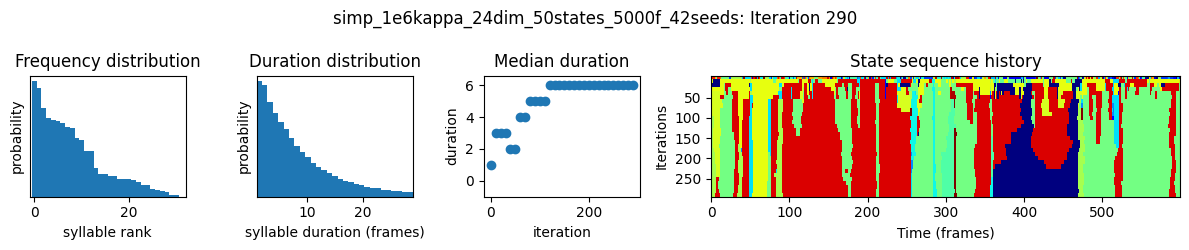

 20%|██████▎                         | 50/251 [18:45<1:11:54, 21.47s/it]

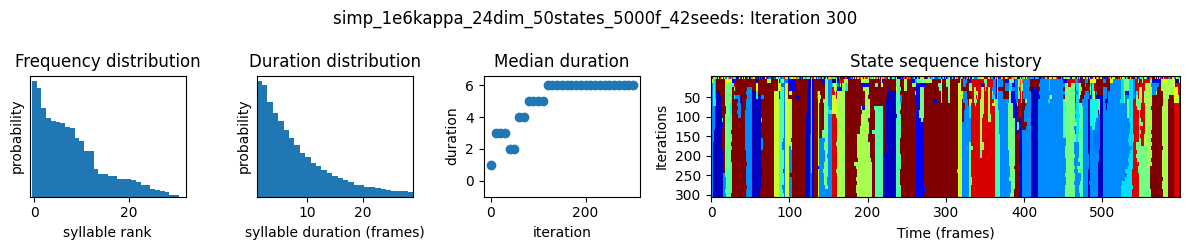

 24%|███████▋                        | 60/251 [22:21<1:08:19, 21.47s/it]

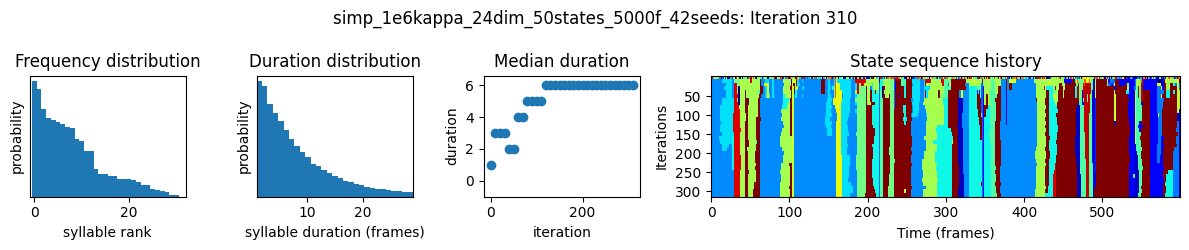

 28%|████████▉                       | 70/251 [25:56<1:04:44, 21.46s/it]

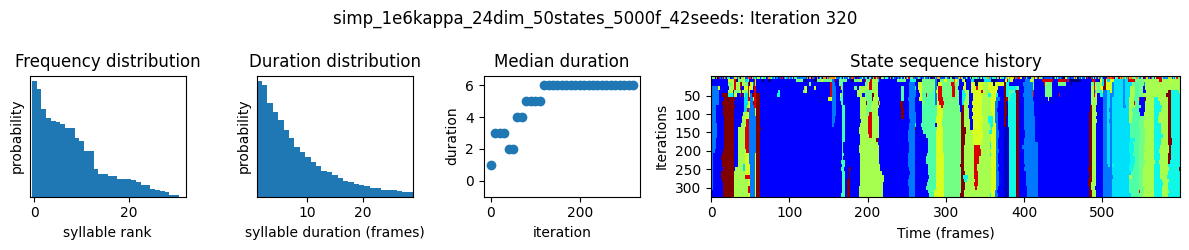

 32%|██████████▏                     | 80/251 [29:32<1:01:10, 21.46s/it]

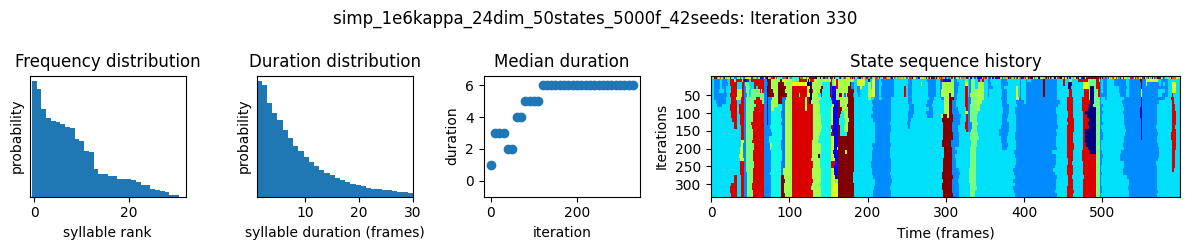

 36%|████████████▏                     | 90/251 [33:08<57:35, 21.46s/it]

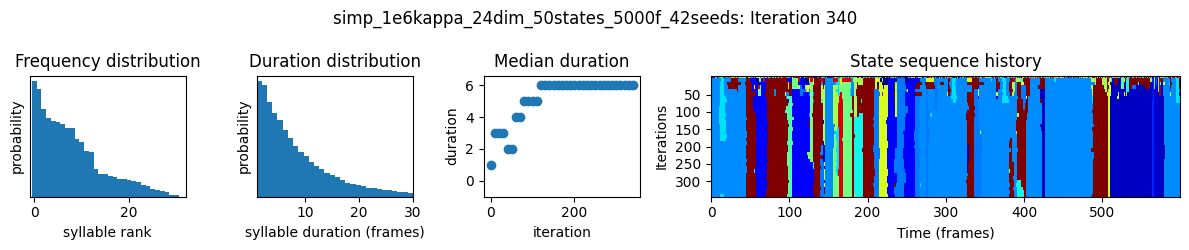

 40%|█████████████▏                   | 100/251 [36:44<54:01, 21.46s/it]

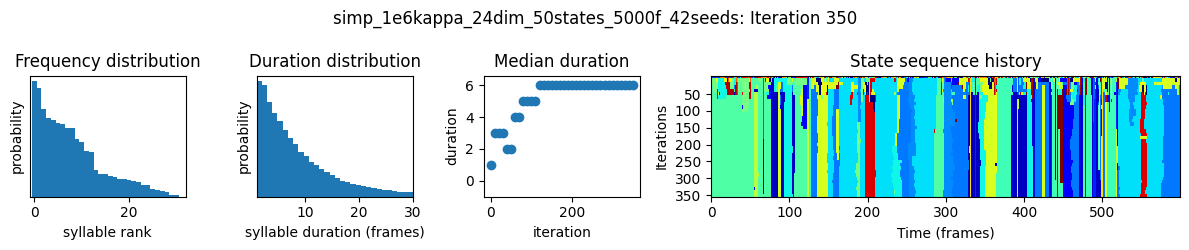

 44%|██████████████▍                  | 110/251 [40:20<50:26, 21.46s/it]

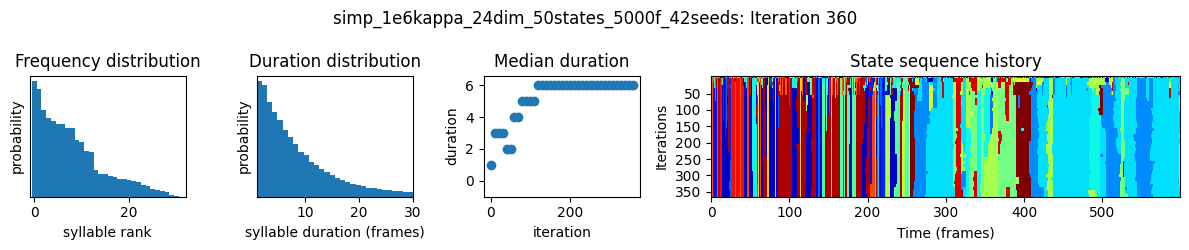

 48%|███████████████▊                 | 120/251 [43:56<46:51, 21.46s/it]

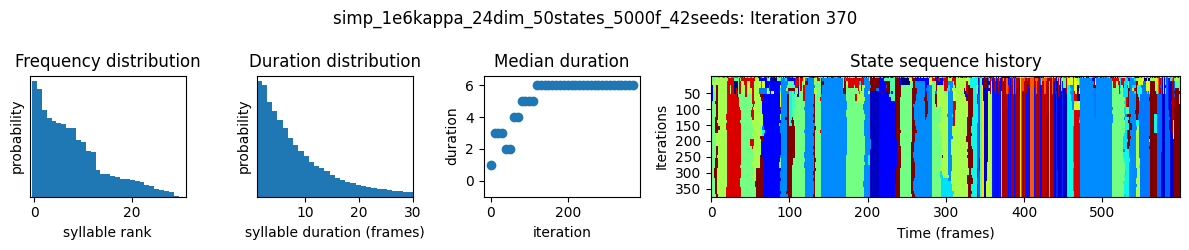

 52%|█████████████████                | 130/251 [47:32<43:17, 21.46s/it]

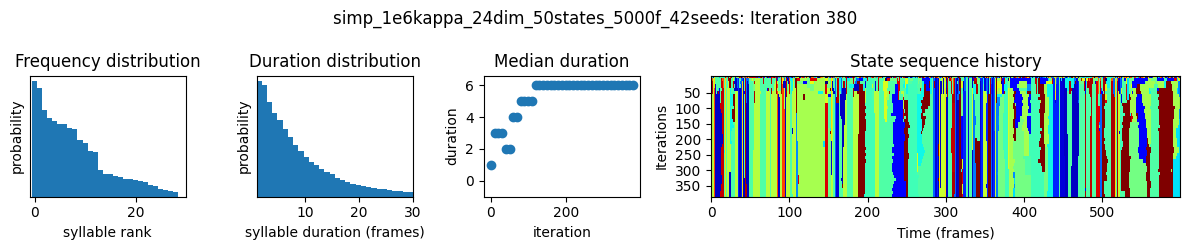

 56%|██████████████████▍              | 140/251 [51:08<39:42, 21.46s/it]

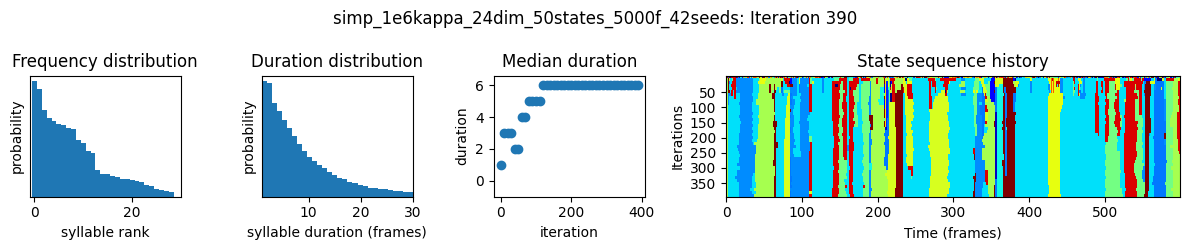

 60%|███████████████████▋             | 150/251 [54:43<36:07, 21.46s/it]

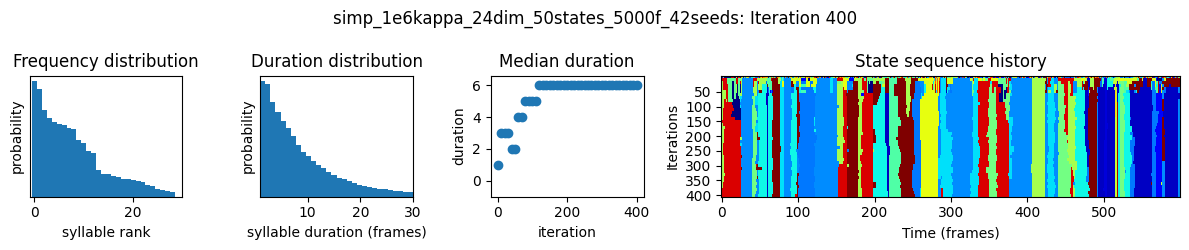

 64%|█████████████████████            | 160/251 [58:19<32:33, 21.46s/it]

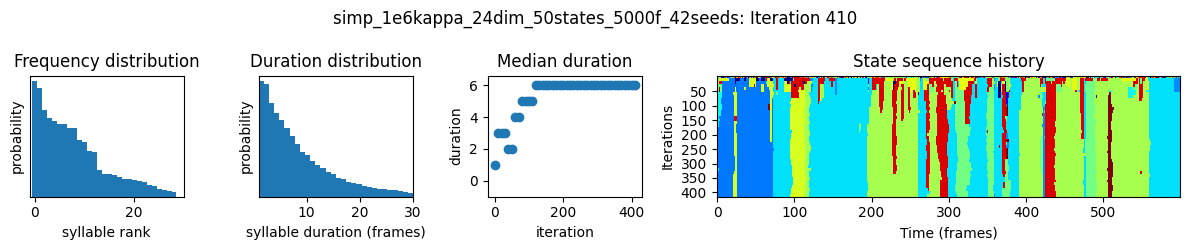

 68%|████████████████████▉          | 170/251 [1:01:55<28:58, 21.46s/it]

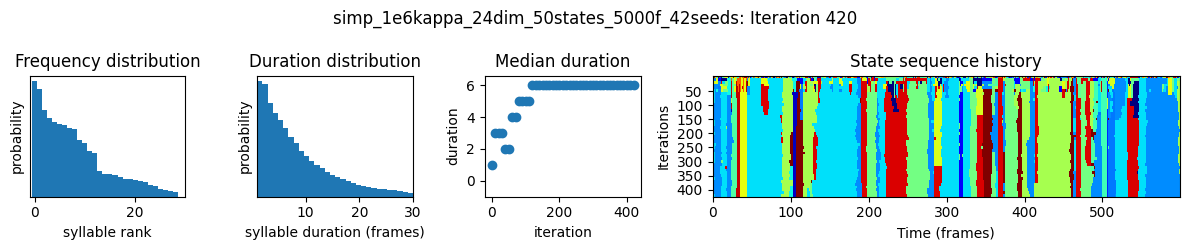

 72%|██████████████████████▏        | 180/251 [1:05:31<25:23, 21.46s/it]

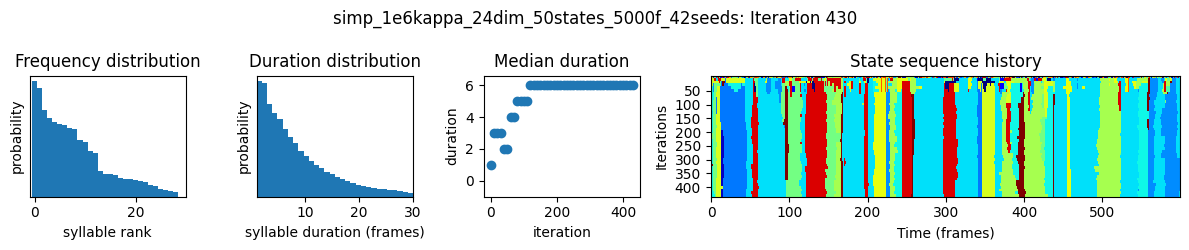

 76%|███████████████████████▍       | 190/251 [1:09:07<21:49, 21.47s/it]

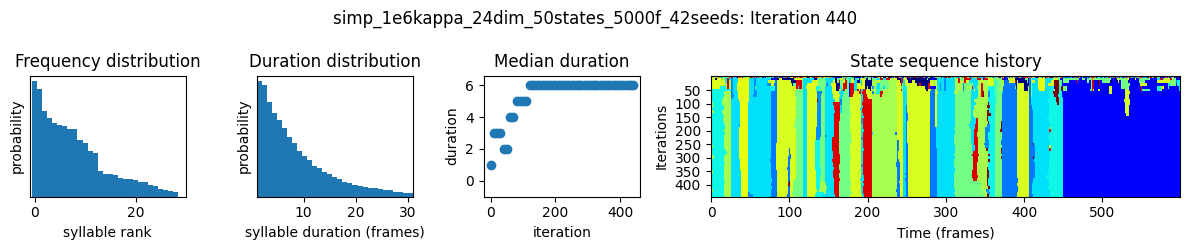

 80%|████████████████████████▋      | 200/251 [1:12:43<18:14, 21.46s/it]

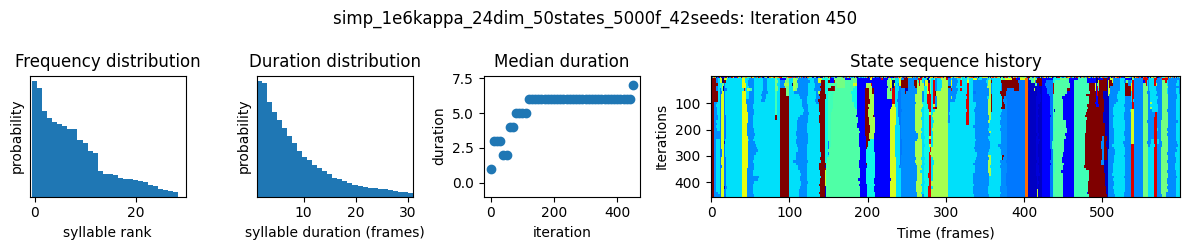

 84%|█████████████████████████▉     | 210/251 [1:16:19<14:39, 21.46s/it]

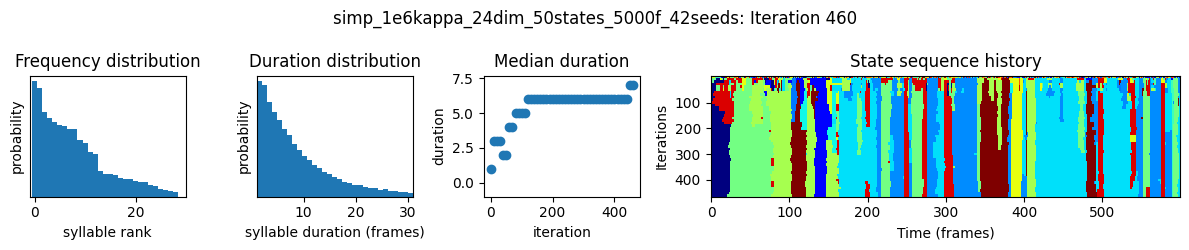

 88%|███████████████████████████▏   | 220/251 [1:19:55<11:05, 21.46s/it]

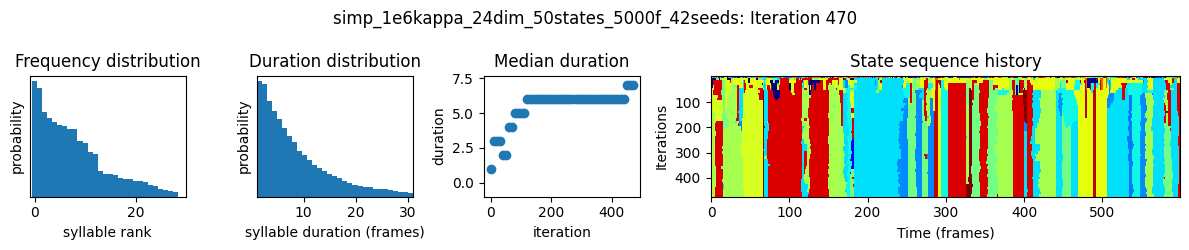

 92%|████████████████████████████▍  | 230/251 [1:23:31<07:30, 21.46s/it]

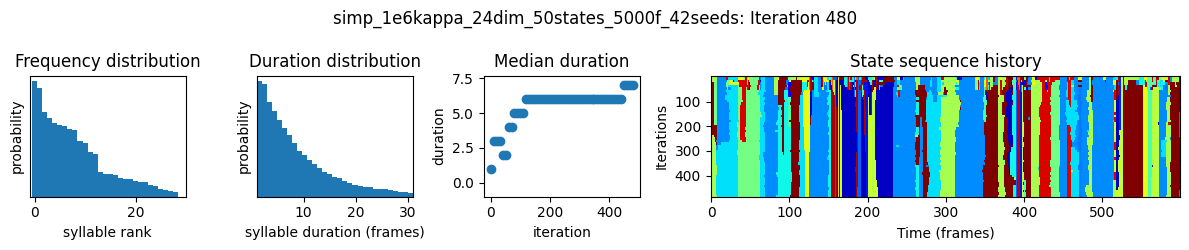

 96%|█████████████████████████████▋ | 240/251 [1:27:07<03:56, 21.46s/it]

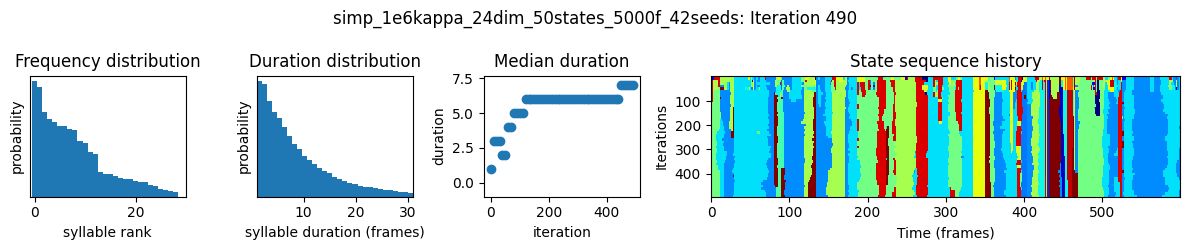

100%|██████████████████████████████▉| 250/251 [1:30:43<00:21, 21.46s/it]

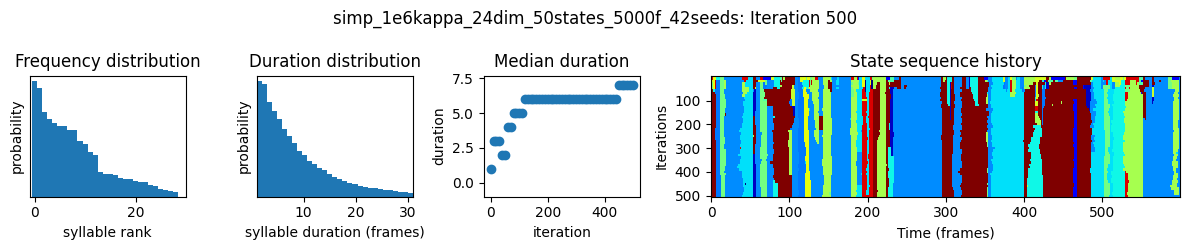

100%|███████████████████████████████| 251/251 [1:31:06<00:00, 21.78s/it]


In [8]:
# load model checkpoint
# model_name = 'simp_1e6kappa_23dim_50states_5000f_0seeds'
num_ar_iters = 250
model, data, metadata, current_iter = kpms.load_checkpoint(
    project_dir, model_name, iteration=num_ar_iters
)

# modify kappa to maintain the desired syllable time-scale
model = kpms.update_hypparams(model, kappa=1e6)

# run fitting for an additional iters
model = kpms.fit_model(
    model,
    data,
    metadata,
    project_dir,
    model_name,
    ar_only=False,
    start_iter=current_iter,
    num_iters=current_iter + 250,
    save_every_n_iters=10
)[0]

#### 2.5.2 Fitting the full model stepwisely.

I am tring to fit the full model stepwisely, that is using a lower and lower `kappa` to fit the model. But fitting restart every `chunk`. So do not run the following cell.

<mark>TODO: Fitting the full model stepwisely.<mark>

In [ ]:
# load model checkpoint
num_ar_iters = 50
# model_name = 'simp_1e6_kappa'
model, data, metadata, ar_only_it = kpms.load_checkpoint(
    project_dir, model_name, iteration=num_ar_iters
)
kappa_start = 1e6
kappa_end = 1e6
total_iters = 100
chunk = 10  # step size for each update
for it in range(0, total_iters-ar_only_it, chunk):
    frac = (it + chunk) / total_iters
    kappa = kappa_start + (kappa_end - kappa_start) * frac
    model = kpms.update_hypparams(model, kappa=kappa)
    model= kpms.fit_model(
        model, 
        data, 
        metadata, 
        project_dir, 
        model_name, 
        ar_only=False, 
        start_iter=ar_only_it + it, 
        num_iters=ar_only_it + it + chunk, 
        save_every_n_iters=10,
        )[0]

#### 2.5.2 Evaluating model.

Author given a function to compute the `expected_marginal_likelihoods`, I modified it to fit iterations and plot the result to help me select iterations. You can also select iterations based on the median duration and state sequence history.

In [10]:
from jax_moseq.models.arhmm import marginal_log_likelihood
import jax.numpy as jnp
import numpy as np
import pandas as pd
import os
import tqdm
from textwrap import fill

def expected_marginal_likelihoods(
    project_dir=None, model_names=None, checkpoint_paths=None, iterations=None
):
    """
    Compute expected marginal likelihoods for multiple models across checkpoints.
    """
    if checkpoint_paths is None:
        assert project_dir is not None and model_names is not None, fill(
            "Must provide either `checkpoint_paths` or (`project_dir` and `model_names`)."
        )
        checkpoint_paths = [
            os.path.join(project_dir, model_name, "checkpoint.h5")
            for model_name in model_names
        ]

    if iterations is None:
        iterations = [0]

    xs, params = [], []
    for checkpoint_path in checkpoint_paths:
        for iteration in iterations:
            model, data, _, _ = kpms.load_checkpoint(path=checkpoint_path, iteration=iteration)
            xs.append(model["states"]["x"])
            params.append(model["params"])

    num_models = len(xs)
    if num_models == 0:
        raise ValueError("No valid checkpoints loaded. Check your paths or iteration list.")

    mlls = np.zeros((num_models, num_models))
    for i in tqdm.trange(num_models, ncols=72, desc="Computing marginal likelihoods"):
        for j in range(num_models):
            if i != j:
                mlls[i, j] = marginal_log_likelihood(
                    jnp.array(data["mask"]),
                    jnp.array(xs[j]),
                    jnp.array(params[i]["Ab"]),
                    jnp.array(params[i]["Q"]),
                    jnp.array(params[i]["pi"]),
                ).item()

    scores = mlls.sum(1) / (num_models - 1)
    variances = (mlls**2).sum(1) / (num_models - 1) - scores**2
    standard_errors = np.sqrt(variances / (num_models - 1))
    return scores, standard_errors
iterations = list(range(200, 501, 10))
model_name = 'simp_1e6kappa_24dim_50states_5000f_42seeds'
scores, std_errs = expected_marginal_likelihoods(
    project_dir, 
    model_names=[model_name],
    iterations=iterations,
)
records_df = pd.DataFrame({
    "iteration": iterations,
    "score": scores
})

records_df.to_csv(f"{project_dir}/{model_name}/marginal_likelihoods.csv", index=False)

Computing marginal likelihoods: 100%|███| 31/31 [15:01<00:00, 29.07s/it]


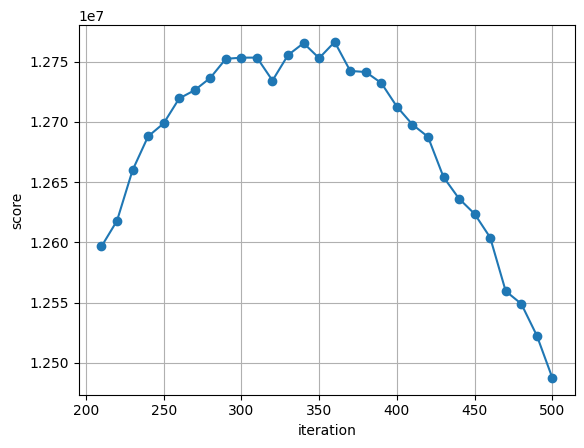

    iteration         score
0         200  1.256334e+07
1         210  1.259650e+07
2         220  1.261783e+07
3         230  1.265974e+07
4         240  1.268786e+07
5         250  1.269868e+07
6         260  1.271933e+07
7         270  1.272623e+07
8         280  1.273641e+07
9         290  1.275223e+07
10        300  1.275320e+07
11        310  1.275324e+07
12        320  1.273421e+07
13        330  1.275536e+07
14        340  1.276526e+07
15        350  1.275278e+07
16        360  1.276626e+07
17        370  1.274219e+07
18        380  1.274129e+07
19        390  1.273214e+07
20        400  1.271258e+07
21        410  1.269769e+07
22        420  1.268754e+07
23        430  1.265408e+07
24        440  1.263616e+07
25        450  1.262354e+07
26        460  1.260394e+07
27        470  1.255945e+07
28        480  1.254895e+07
29        490  1.252262e+07
30        500  1.248743e+07


In [11]:
import matplotlib.pyplot as plt

plt.plot(iterations[1:], scores[1:], marker='o')
plt.xlabel('iteration')
plt.ylabel('score')
plt.grid(True)
plt.savefig(f"{project_dir}/{model_name}/likelihood_curve.png")
plt.show()
print(records_df)

### 2.6 Sort syllables by frequency.

Permute the states and parameters of a saved checkpoint so that syllables are labeled in order of frequency (i.e. so that 0 is the most frequent, 1 is the second most, and so on).

In [36]:
# modify a saved checkpoint so syllables are ordered by frequency
model_name = 'kappa_scan_1e+08'
kpms.reindex_syllables_in_checkpoint(project_dir, model_name)

Reindexing: 100%|███████████| 46/46 [00:40<00:00,  1.15model snapshot/s]


array([17, 27, 13, 49, 45, 22, 12, 31,  6, 18,  3,  0, 29, 47, 30,  7, 46,
       21, 24, 41,  4, 33,  1,  8,  2, 11, 42, 44, 48, 40, 23, 28, 20, 25,
       10, 16, 38,  9, 34, 26, 39, 32, 43,  5, 14, 35, 37, 19, 36, 15])

### 2.7 Extract model results.

Parse the modeling results and save them to `{project_dir}/{model_name}/results.h5`. The results are stored as follows, and can be reloaded at a later time using `kpms.load_results`. Check the docs for an in-depth explanation of the modeling results.

```text
    results.h5
    ├──recording_name1
    │  ├──syllable      # syllable labels (z)
    │  ├──latent_state  # inferred low-dim pose state (x)
    │  ├──centroid      # inferred centroid (v)
    │  └──heading       # inferred heading (h)
    ⋮
```

In [37]:
# load the selected model checkpoint
model, data, metadata, current_iter = kpms.load_checkpoint(
    project_dir, 
    model_name, 
    iteration=450  # specify the iteration you want to load
    )

# extract results
results = kpms.extract_results(model, metadata, project_dir, model_name, save_results=True)


Saved results to
/home/gxj/Desktop/gxj/kpms_project/kappa_scan_1e+08/results.h5


In [38]:
# optionally save results as csv
kpms.save_results_as_csv(results, project_dir, model_name)

Saving to csv:   0%|                            | 0/205 [00:00<?, ?it/s]

Saving to csv: 100%|██████████████████| 205/205 [00:18<00:00, 11.24it/s]


### 2.8 Apply to new data.

The code below shows how to apply a trained model to new data. This is useful if you have performed new experiments and would like to maintain an existing set of syllables. The results for the new experiments will be added to the existing `results.h5` file. **This step is optional and can be skipped if you do not have new data to add.**

#### 2.8.1 Load new data you want.

In [20]:
import yaml
from analyze_data_3d_utils import DataProcessor

with open("analyze_data_3d_cfg.yaml", "r") as f:
    cfg = yaml.safe_load(f)

fps = cfg["fps"]
joint_names = cfg["joint_names"]
limb_combos = cfg["limb_combos"]
limb_orders = cfg["limb_orders"]
joint_creds = cfg["joint_creds"]
skel_conns = [tuple(pair) for pair in cfg["skel_conns"]]  # convert to tuples.


new_data = "/home/gxj/Desktop/Synology25/dannce_results/exp_111/save_data_AVG0.mat"  # can be a file, a directory, or a list of files
coordinates, confidences, bodyparts = kpms.load_keypoints(new_data, "dannce", path_in_name=True)
for recording_name in coordinates:
    raw_coords = coordinates[recording_name].copy()
    outliers = kpms.find_medoid_distance_outliers(raw_coords, **config())  # Use Median Absolute Deviation.
    outliers_ = DataProcessor.find_RULE_outliers(
        raw_coords, joint_names, limb_orders, skel_conns, joint_creds, 
        prev_outliers=outliers, outlier_scale_factors={'velocity': 5, 'angle': 5, 'displacement': 5})
    coordinates[recording_name] = kpms.interpolate_keypoints(raw_coords, outliers_["mask"])  # linear interpolation
    confidences[recording_name] = np.where(outliers_["mask"], 0, confidences[recording_name])
    kpms.plot_medoid_distance_outliers(
        project_dir,
        recording_name,
        raw_coords,
        coordinates[recording_name],
        outliers["mask"],
        outliers["thresholds"],
        joint_names
    )

coordinates, simp_joint_names = DataProcessor.simplify_coord_dict(
    coordinates, joint_names, limb_combos
)
confidences, simp_joint_names = DataProcessor.simplify_coord_dict(
    confidences, joint_names, limb_combos
)
print(confidences[list(confidences.keys())[0]].shape)
print(coordinates[list(confidences.keys())[0]].shape)
data, metadata = kpms.format_data(coordinates, confidences, **config())

# load the most recent model checkpoint and pca object
model_name = "kappa_scan_1e+03"
model = kpms.load_checkpoint(project_dir, model_name, iteration=450)[0]

# apply saved model to new data
results = kpms.apply_model(model, data, metadata, project_dir, model_name, **config())

# optionally rerun `save_results_as_csv` to export the new results
kpms.save_results_as_csv(results, project_dir, model_name)

Loading keypoints: 100%|██████████████████| 1/1 [00:00<00:00,  7.93it/s]


Saved keypoint distance outlier plot for -home-gxj-Desktop-Synology25-dannce_results-exp_111-save_data_AVG0 to /home/gxj/Desktop/gxj/kpms_project/quality_assurance/plots/keypoint_distance_outliers/-home-gxj-Desktop-Synology25-dannce_results-exp_111-save_data_AVG0.png.
(60313, 15)
(60313, 15, 3)


Applying model: 100%|█████████████████| 500/500 [20:58<00:00,  2.52s/it]


Saved results to
/home/gxj/Desktop/gxj/kpms_project/kappa_scan_1e+03/results.h5


Saving to csv: 100%|██████████████████████| 1/1 [00:01<00:00,  1.01s/it]


#### 2.8.2 Load all sessions data.

In [ ]:
import pickle
from datetime import datetime

# load the most recent model checkpoint and pca object
model_name = "simp_1e6kappa_23dim_50states_5000f_0seeds"
model = kpms.load_checkpoint(project_dir, model_name, iteration=200)[0]

with open(f'{project_dir}/simp_kpms_data.pkl', 'rb') as f:
    simp_kpms_data = pickle.load(f)  # correceted and simplified all sessions data
coordinates = simp_kpms_data['coordinates']
confidences = simp_kpms_data['confidences']
print(confidences[list(confidences.keys())[0]].shape)
print(coordinates[list(confidences.keys())[0]].shape)

for sess_id in coordinates.keys():
    print(sess_id, datetime.now().strftime("%Y-%m-%d %H:%M:%S.%f"))
    coords = coordinates[sess_id].copy()
    confs = confidences[sess_id].copy()
    # format data for kpms
    data, metadata = kpms.format_data({sess_id: coords}, {sess_id: confs}, **config())
    # apply saved model to new data
    results = kpms.apply_model(model, data, metadata, project_dir, model_name, **config())
    # optionally rerun `save_results_as_csv` to export the new results
    kpms.save_results_as_csv(results, project_dir, model_name)


(60313, 15)
(60313, 15, 3)


Applying model: 100%|█████████████████| 500/500 [22:22<00:00,  2.68s/it]


Saved results to /home/gxj/Desktop/gxj/kpms_project/simp_1e6kappa_23di
m_50states_5000f_0seeds/results.h5


Applying model: 100%|█████████████████| 500/500 [21:47<00:00,  2.62s/it]


Saved results to /home/gxj/Desktop/gxj/kpms_project/simp_1e6kappa_23di
m_50states_5000f_0seeds/results.h5


Applying model: 100%|█████████████████| 500/500 [21:47<00:00,  2.61s/it]


Saved results to /home/gxj/Desktop/gxj/kpms_project/simp_1e6kappa_23di
m_50states_5000f_0seeds/results.h5


Applying model: 100%|█████████████████| 500/500 [21:45<00:00,  2.61s/it]


Saved results to /home/gxj/Desktop/gxj/kpms_project/simp_1e6kappa_23di
m_50states_5000f_0seeds/results.h5


Applying model: 100%|█████████████████| 500/500 [21:45<00:00,  2.61s/it]


Saved results to /home/gxj/Desktop/gxj/kpms_project/simp_1e6kappa_23di
m_50states_5000f_0seeds/results.h5


Applying model: 100%|█████████████████| 500/500 [21:45<00:00,  2.61s/it]


Saved results to /home/gxj/Desktop/gxj/kpms_project/simp_1e6kappa_23di
m_50states_5000f_0seeds/results.h5


Applying model: 100%|█████████████████| 500/500 [21:45<00:00,  2.61s/it]


Saved results to /home/gxj/Desktop/gxj/kpms_project/simp_1e6kappa_23di
m_50states_5000f_0seeds/results.h5


Applying model: 100%|█████████████████| 500/500 [21:46<00:00,  2.61s/it]


Saved results to /home/gxj/Desktop/gxj/kpms_project/simp_1e6kappa_23di
m_50states_5000f_0seeds/results.h5


Applying model: 100%|█████████████████| 500/500 [21:49<00:00,  2.62s/it]


Saved results to /home/gxj/Desktop/gxj/kpms_project/simp_1e6kappa_23di
m_50states_5000f_0seeds/results.h5


Applying model: 100%|█████████████████| 500/500 [21:51<00:00,  2.62s/it]


Saved results to /home/gxj/Desktop/gxj/kpms_project/simp_1e6kappa_23di
m_50states_5000f_0seeds/results.h5


Applying model: 100%|█████████████████| 500/500 [21:46<00:00,  2.61s/it]


Saved results to /home/gxj/Desktop/gxj/kpms_project/simp_1e6kappa_23di
m_50states_5000f_0seeds/results.h5


Applying model: 100%|█████████████████| 500/500 [21:46<00:00,  2.61s/it]


Saved results to /home/gxj/Desktop/gxj/kpms_project/simp_1e6kappa_23di
m_50states_5000f_0seeds/results.h5


Applying model: 100%|█████████████████| 500/500 [21:51<00:00,  2.62s/it]


Saved results to /home/gxj/Desktop/gxj/kpms_project/simp_1e6kappa_23di
m_50states_5000f_0seeds/results.h5


Applying model: 100%|█████████████████| 500/500 [21:48<00:00,  2.62s/it]


Saved results to /home/gxj/Desktop/gxj/kpms_project/simp_1e6kappa_23di
m_50states_5000f_0seeds/results.h5


Applying model: 100%|█████████████████| 500/500 [21:47<00:00,  2.61s/it]


Saved results to /home/gxj/Desktop/gxj/kpms_project/simp_1e6kappa_23di
m_50states_5000f_0seeds/results.h5


Applying model: 100%|█████████████████| 500/500 [21:47<00:00,  2.62s/it]


Saved results to /home/gxj/Desktop/gxj/kpms_project/simp_1e6kappa_23di
m_50states_5000f_0seeds/results.h5


Applying model: 100%|█████████████████| 500/500 [21:54<00:00,  2.63s/it]


Saved results to /home/gxj/Desktop/gxj/kpms_project/simp_1e6kappa_23di
m_50states_5000f_0seeds/results.h5


Applying model: 100%|█████████████████| 500/500 [21:50<00:00,  2.62s/it]


Saved results to /home/gxj/Desktop/gxj/kpms_project/simp_1e6kappa_23di
m_50states_5000f_0seeds/results.h5


Applying model: 100%|█████████████████| 500/500 [24:15<00:00,  2.91s/it]


Saved results to /home/gxj/Desktop/gxj/kpms_project/simp_1e6kappa_23di
m_50states_5000f_0seeds/results.h5


Applying model: 100%|█████████████████| 500/500 [21:55<00:00,  2.63s/it]


Saved results to /home/gxj/Desktop/gxj/kpms_project/simp_1e6kappa_23di
m_50states_5000f_0seeds/results.h5


Applying model: 100%|█████████████████| 500/500 [21:54<00:00,  2.63s/it]


Saved results to /home/gxj/Desktop/gxj/kpms_project/simp_1e6kappa_23di
m_50states_5000f_0seeds/results.h5


Applying model: 100%|█████████████████| 500/500 [21:48<00:00,  2.62s/it]


Saved results to /home/gxj/Desktop/gxj/kpms_project/simp_1e6kappa_23di
m_50states_5000f_0seeds/results.h5


Applying model: 100%|█████████████████| 500/500 [21:50<00:00,  2.62s/it]


Saved results to /home/gxj/Desktop/gxj/kpms_project/simp_1e6kappa_23di
m_50states_5000f_0seeds/results.h5


Applying model: 100%|█████████████████| 500/500 [21:50<00:00,  2.62s/it]


Saved results to /home/gxj/Desktop/gxj/kpms_project/simp_1e6kappa_23di
m_50states_5000f_0seeds/results.h5


Applying model: 100%|█████████████████| 500/500 [21:51<00:00,  2.62s/it]


Saved results to /home/gxj/Desktop/gxj/kpms_project/simp_1e6kappa_23di
m_50states_5000f_0seeds/results.h5


Applying model: 100%|█████████████████| 500/500 [21:50<00:00,  2.62s/it]


Saved results to /home/gxj/Desktop/gxj/kpms_project/simp_1e6kappa_23di
m_50states_5000f_0seeds/results.h5


Applying model: 100%|█████████████████| 500/500 [21:51<00:00,  2.62s/it]


Saved results to /home/gxj/Desktop/gxj/kpms_project/simp_1e6kappa_23di
m_50states_5000f_0seeds/results.h5


Applying model: 100%|█████████████████| 500/500 [21:50<00:00,  2.62s/it]


Saved results to /home/gxj/Desktop/gxj/kpms_project/simp_1e6kappa_23di
m_50states_5000f_0seeds/results.h5


Applying model: 100%|█████████████████| 500/500 [21:49<00:00,  2.62s/it]


Saved results to /home/gxj/Desktop/gxj/kpms_project/simp_1e6kappa_23di
m_50states_5000f_0seeds/results.h5


Applying model: 100%|█████████████████| 500/500 [21:49<00:00,  2.62s/it]


Saved results to /home/gxj/Desktop/gxj/kpms_project/simp_1e6kappa_23di
m_50states_5000f_0seeds/results.h5


Applying model: 100%|█████████████████| 500/500 [21:49<00:00,  2.62s/it]


Saved results to /home/gxj/Desktop/gxj/kpms_project/simp_1e6kappa_23di
m_50states_5000f_0seeds/results.h5


Applying model: 100%|█████████████████| 500/500 [21:50<00:00,  2.62s/it]


Saved results to /home/gxj/Desktop/gxj/kpms_project/simp_1e6kappa_23di
m_50states_5000f_0seeds/results.h5


Applying model: 100%|█████████████████| 500/500 [21:50<00:00,  2.62s/it]


Saved results to /home/gxj/Desktop/gxj/kpms_project/simp_1e6kappa_23di
m_50states_5000f_0seeds/results.h5


Applying model: 100%|█████████████████| 500/500 [21:49<00:00,  2.62s/it]


Saved results to /home/gxj/Desktop/gxj/kpms_project/simp_1e6kappa_23di
m_50states_5000f_0seeds/results.h5


Applying model: 100%|█████████████████| 500/500 [21:48<00:00,  2.62s/it]


Saved results to /home/gxj/Desktop/gxj/kpms_project/simp_1e6kappa_23di
m_50states_5000f_0seeds/results.h5


Applying model: 100%|█████████████████| 500/500 [21:48<00:00,  2.62s/it]


Saved results to /home/gxj/Desktop/gxj/kpms_project/simp_1e6kappa_23di
m_50states_5000f_0seeds/results.h5


Applying model: 100%|█████████████████| 500/500 [21:48<00:00,  2.62s/it]


Saved results to /home/gxj/Desktop/gxj/kpms_project/simp_1e6kappa_23di
m_50states_5000f_0seeds/results.h5


Applying model: 100%|█████████████████| 500/500 [21:49<00:00,  2.62s/it]


Saved results to /home/gxj/Desktop/gxj/kpms_project/simp_1e6kappa_23di
m_50states_5000f_0seeds/results.h5


Applying model: 100%|█████████████████| 500/500 [21:48<00:00,  2.62s/it]


Saved results to /home/gxj/Desktop/gxj/kpms_project/simp_1e6kappa_23di
m_50states_5000f_0seeds/results.h5


Applying model: 100%|█████████████████| 500/500 [21:48<00:00,  2.62s/it]


Saved results to /home/gxj/Desktop/gxj/kpms_project/simp_1e6kappa_23di
m_50states_5000f_0seeds/results.h5


Applying model: 100%|█████████████████| 500/500 [21:48<00:00,  2.62s/it]


Saved results to /home/gxj/Desktop/gxj/kpms_project/simp_1e6kappa_23di
m_50states_5000f_0seeds/results.h5


Applying model: 100%|█████████████████| 500/500 [21:49<00:00,  2.62s/it]


Saved results to /home/gxj/Desktop/gxj/kpms_project/simp_1e6kappa_23di
m_50states_5000f_0seeds/results.h5


Applying model: 100%|█████████████████| 500/500 [21:49<00:00,  2.62s/it]


Saved results to /home/gxj/Desktop/gxj/kpms_project/simp_1e6kappa_23di
m_50states_5000f_0seeds/results.h5


Applying model: 100%|█████████████████| 500/500 [21:48<00:00,  2.62s/it]


Saved results to /home/gxj/Desktop/gxj/kpms_project/simp_1e6kappa_23di
m_50states_5000f_0seeds/results.h5


Applying model: 100%|█████████████████| 500/500 [21:47<00:00,  2.62s/it]


Saved results to /home/gxj/Desktop/gxj/kpms_project/simp_1e6kappa_23di
m_50states_5000f_0seeds/results.h5


Applying model: 100%|█████████████████| 500/500 [21:48<00:00,  2.62s/it]


Saved results to /home/gxj/Desktop/gxj/kpms_project/simp_1e6kappa_23di
m_50states_5000f_0seeds/results.h5


Applying model: 100%|█████████████████| 500/500 [21:50<00:00,  2.62s/it]


Saved results to /home/gxj/Desktop/gxj/kpms_project/simp_1e6kappa_23di
m_50states_5000f_0seeds/results.h5


Applying model: 100%|█████████████████| 500/500 [21:50<00:00,  2.62s/it]


Saved results to /home/gxj/Desktop/gxj/kpms_project/simp_1e6kappa_23di
m_50states_5000f_0seeds/results.h5


Applying model: 100%|█████████████████| 500/500 [21:49<00:00,  2.62s/it]


Saved results to /home/gxj/Desktop/gxj/kpms_project/simp_1e6kappa_23di
m_50states_5000f_0seeds/results.h5


Applying model: 100%|█████████████████| 500/500 [21:49<00:00,  2.62s/it]


Saved results to /home/gxj/Desktop/gxj/kpms_project/simp_1e6kappa_23di
m_50states_5000f_0seeds/results.h5


Applying model: 100%|█████████████████| 500/500 [21:49<00:00,  2.62s/it]


Saved results to /home/gxj/Desktop/gxj/kpms_project/simp_1e6kappa_23di
m_50states_5000f_0seeds/results.h5


Applying model: 100%|█████████████████| 500/500 [21:50<00:00,  2.62s/it]


Saved results to /home/gxj/Desktop/gxj/kpms_project/simp_1e6kappa_23di
m_50states_5000f_0seeds/results.h5


Applying model: 100%|█████████████████| 500/500 [21:49<00:00,  2.62s/it]


Saved results to /home/gxj/Desktop/gxj/kpms_project/simp_1e6kappa_23di
m_50states_5000f_0seeds/results.h5


Applying model: 100%|█████████████████| 500/500 [21:48<00:00,  2.62s/it]


Saved results to /home/gxj/Desktop/gxj/kpms_project/simp_1e6kappa_23di
m_50states_5000f_0seeds/results.h5


Applying model: 100%|█████████████████| 500/500 [21:46<00:00,  2.61s/it]


Saved results to /home/gxj/Desktop/gxj/kpms_project/simp_1e6kappa_23di
m_50states_5000f_0seeds/results.h5


Applying model: 100%|█████████████████| 500/500 [21:48<00:00,  2.62s/it]


Saved results to /home/gxj/Desktop/gxj/kpms_project/simp_1e6kappa_23di
m_50states_5000f_0seeds/results.h5


Applying model: 100%|█████████████████| 500/500 [21:46<00:00,  2.61s/it]


Saved results to /home/gxj/Desktop/gxj/kpms_project/simp_1e6kappa_23di
m_50states_5000f_0seeds/results.h5


Applying model: 100%|█████████████████| 500/500 [21:46<00:00,  2.61s/it]


Saved results to /home/gxj/Desktop/gxj/kpms_project/simp_1e6kappa_23di
m_50states_5000f_0seeds/results.h5


Applying model: 100%|█████████████████| 500/500 [21:46<00:00,  2.61s/it]


Saved results to /home/gxj/Desktop/gxj/kpms_project/simp_1e6kappa_23di
m_50states_5000f_0seeds/results.h5


Applying model: 100%|█████████████████| 500/500 [21:48<00:00,  2.62s/it]


Saved results to /home/gxj/Desktop/gxj/kpms_project/simp_1e6kappa_23di
m_50states_5000f_0seeds/results.h5


Applying model: 100%|█████████████████| 500/500 [21:47<00:00,  2.62s/it]


Saved results to /home/gxj/Desktop/gxj/kpms_project/simp_1e6kappa_23di
m_50states_5000f_0seeds/results.h5


Applying model: 100%|█████████████████| 500/500 [21:46<00:00,  2.61s/it]


Saved results to /home/gxj/Desktop/gxj/kpms_project/simp_1e6kappa_23di
m_50states_5000f_0seeds/results.h5


Applying model: 100%|█████████████████| 500/500 [21:46<00:00,  2.61s/it]


Saved results to /home/gxj/Desktop/gxj/kpms_project/simp_1e6kappa_23di
m_50states_5000f_0seeds/results.h5


Applying model: 100%|█████████████████| 500/500 [21:46<00:00,  2.61s/it]


Saved results to /home/gxj/Desktop/gxj/kpms_project/simp_1e6kappa_23di
m_50states_5000f_0seeds/results.h5


Applying model: 100%|█████████████████| 500/500 [21:48<00:00,  2.62s/it]


Saved results to /home/gxj/Desktop/gxj/kpms_project/simp_1e6kappa_23di
m_50states_5000f_0seeds/results.h5


Applying model: 100%|█████████████████| 500/500 [21:48<00:00,  2.62s/it]


Saved results to /home/gxj/Desktop/gxj/kpms_project/simp_1e6kappa_23di
m_50states_5000f_0seeds/results.h5


Applying model: 100%|█████████████████| 500/500 [21:48<00:00,  2.62s/it]


Saved results to /home/gxj/Desktop/gxj/kpms_project/simp_1e6kappa_23di
m_50states_5000f_0seeds/results.h5


Applying model: 100%|█████████████████| 500/500 [21:51<00:00,  2.62s/it]


Saved results to /home/gxj/Desktop/gxj/kpms_project/simp_1e6kappa_23di
m_50states_5000f_0seeds/results.h5


Applying model: 100%|█████████████████| 500/500 [21:49<00:00,  2.62s/it]


Saved results to /home/gxj/Desktop/gxj/kpms_project/simp_1e6kappa_23di
m_50states_5000f_0seeds/results.h5


Applying model: 100%|█████████████████| 500/500 [21:48<00:00,  2.62s/it]


Saved results to /home/gxj/Desktop/gxj/kpms_project/simp_1e6kappa_23di
m_50states_5000f_0seeds/results.h5


Applying model: 100%|█████████████████| 500/500 [21:53<00:00,  2.63s/it]


Saved results to /home/gxj/Desktop/gxj/kpms_project/simp_1e6kappa_23di
m_50states_5000f_0seeds/results.h5


Applying model:  39%|██████▋          | 197/500 [08:38<13:17,  2.63s/it]


Early termination of fitting: user interruption
Saved results to /home/gxj/Desktop/gxj/kpms_project/simp_1e6kappa_23di
m_50states_5000f_0seeds/results.h5


Applying model:   1%|                   | 3/500 [00:07<21:41,  2.62s/it]

In [ ]:
# load the most recent model checkpoint and pca object
model_name = "simp_1e6kappa_23dim_50states_5000f_0seeds"
model = kpms.load_checkpoint(project_dir, model_name, iteration=200)[0]

# apply saved model to new data
results = kpms.apply_model(model, data, metadata, project_dir, model_name, **config())

# optionally rerun `save_results_as_csv` to export the new results
kpms.save_results_as_csv(results, project_dir, model_name)

## 3. Visualization.

### 3.1 Trajectory plots.

Generate plots showing the median trajectory of poses associated with each given syllable.

Saving trajectory plots to /home/gxj/Desktop/gxj/kpms_project/kappa_scan_1e+08/trajectory_plots


Generating trajectory plots: 100%|██████| 28/28 [00:14<00:00,  1.93it/s]


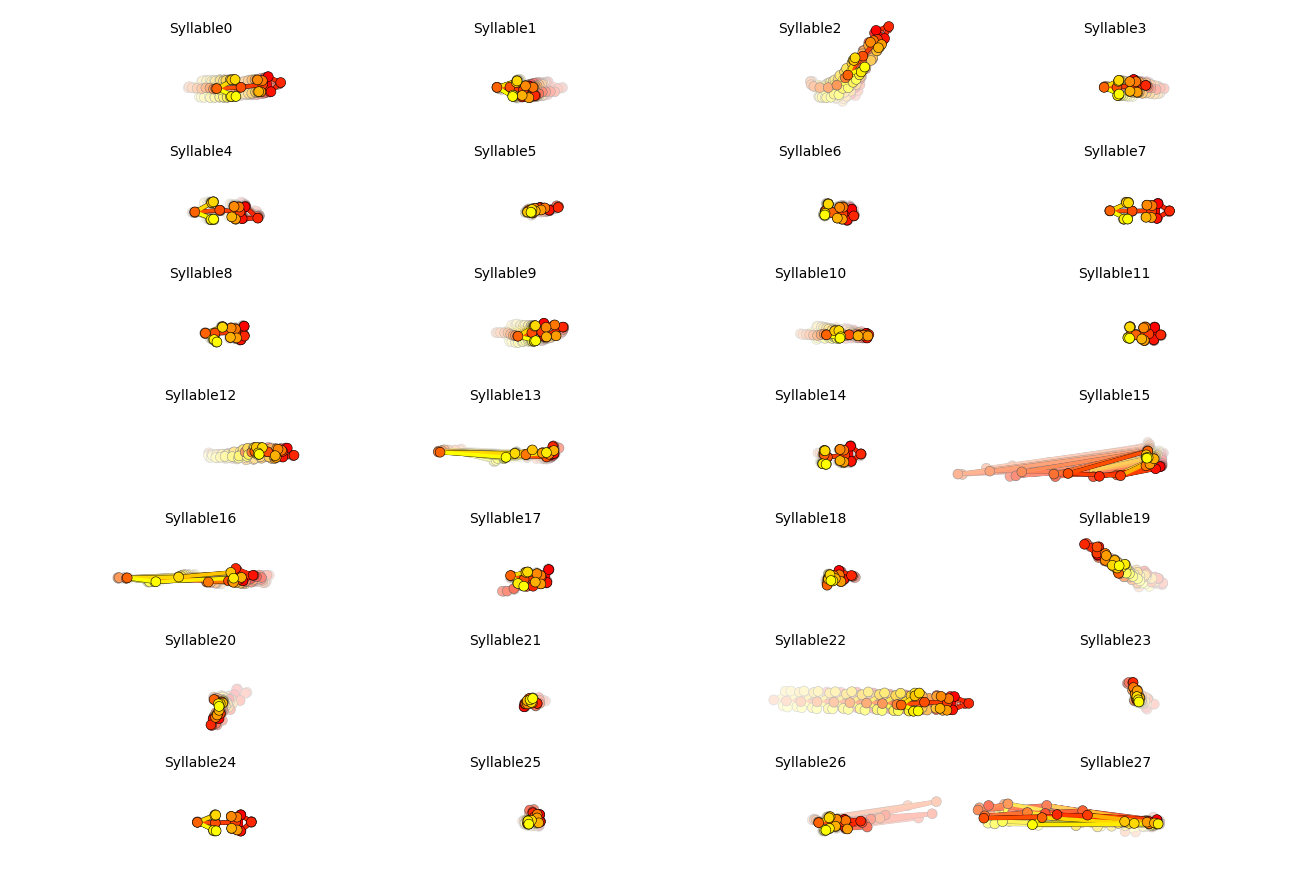

Generating trajectory plots: 100%|██████| 28/28 [00:15<00:00,  1.78it/s]


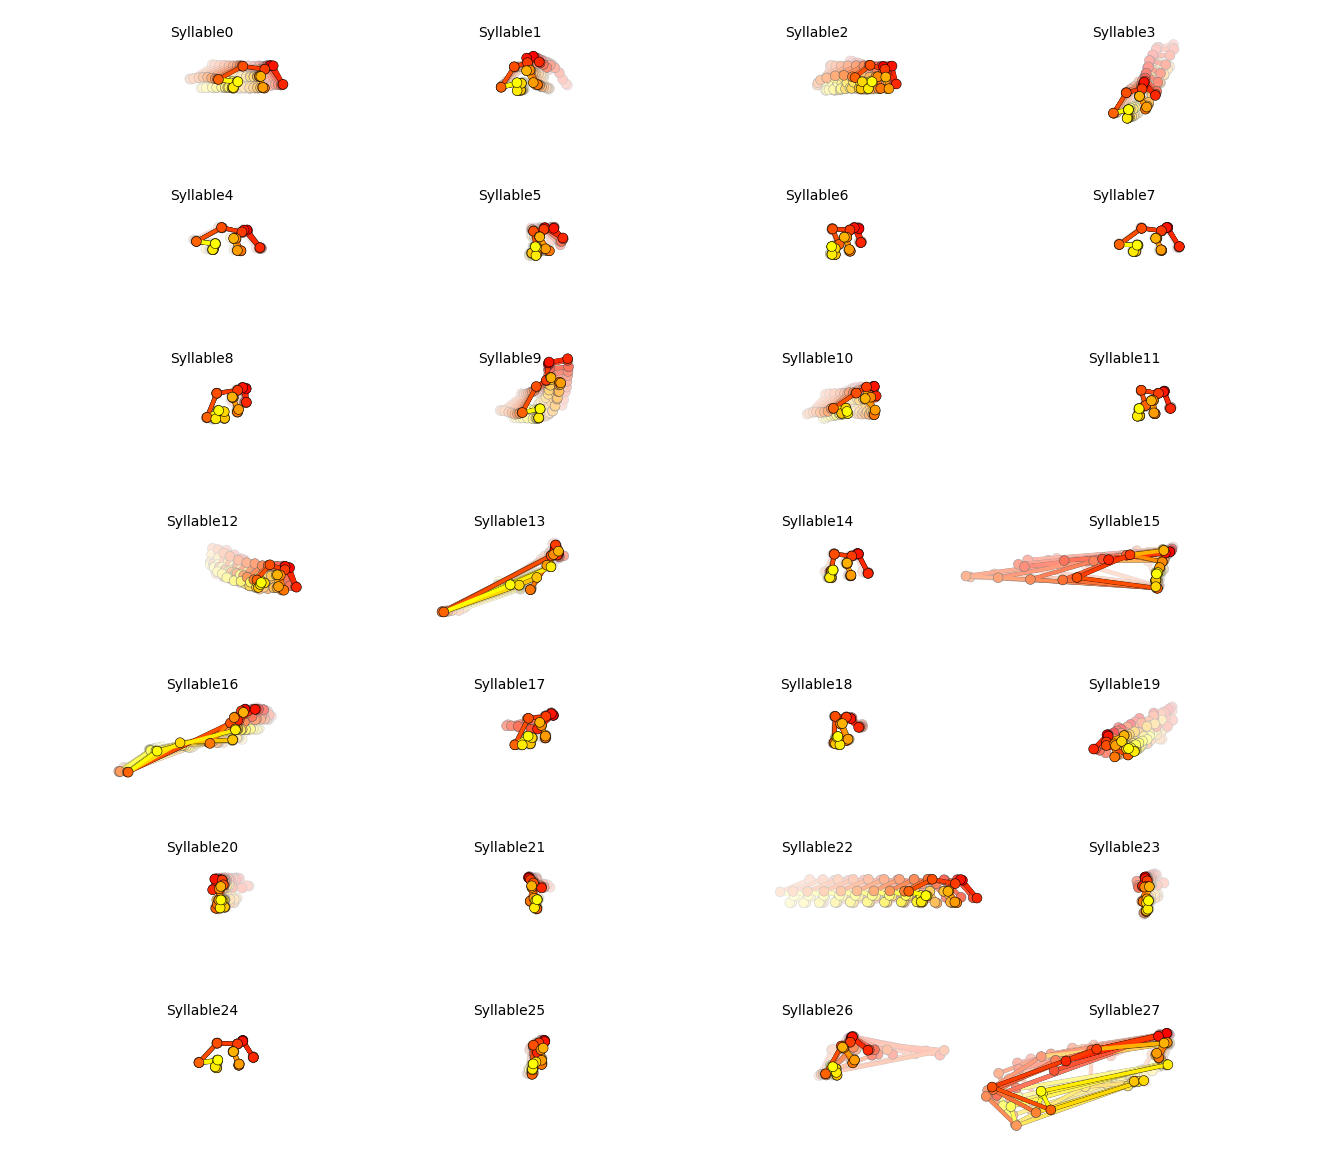

Saved interactive trajectories plot to /home/gxj/Desktop/gxj/kpms_project/kappa_scan_1e+08/trajectory_plots/all_trajectories.html


In [39]:
kpms.generate_trajectory_plots(
    coordinates, 
    results, 
    project_dir, 
    model_name, 
    **config(), 
    min_frequency=0.005, 
    min_duration=3, 
    interactive=True)

### 3.2 Grid movies.

Generate video clips showing examples of each syllable.

Note: the code below will only work with 2D data. For 3D data, see: [Grid movies for 3D data](https://keypoint-moseq.readthedocs.io/en/latest/FAQs.html#making-grid-movies-for-3d-data)

In [21]:
# Grid movies
kpms.generate_grid_movies(
    results, project_dir, model_name, coordinates=coordinates, 
    **config(), pre=0.5, post=0.5, keypoints_scale=5, use_dims=[0, 1], 
    keypoints_only=True);


Writing grid movies to /home/gxj/Desktop/gxj/kpms_project/simp_1e6kappa_24dim_50states/grid_movies


/home/gxj/Desktop/gxj/keypoint-moseq/keypoint_moseq/viz.py:1324: UserWarning:


Videos will be downscaled by a factor of 0.44 so that the grid movies
are under 1920 pixels. Use `max_video_size` to increase or decrease
this size limit.





Using window size of 720 pixels


Generating grid movies:   0%|                    | 0/27 [00:00<?, ?it/s]/home/gxj/.conda/envs/keypoint_moseq/lib/python3.10/subprocess.py:1796: RuntimeWarning:

os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.

Generating grid movies: 100%|███████████| 27/27 [01:34<00:00,  3.48s/it]


### 3.3 Syllable Dendrogram.

Plot a dendrogram representing distances between each syllable’s median trajectory.

Saving dendrogram plot to /home/gxj/Desktop/gxj/kpms_project/kappa_scan_1e+08/similarity_dendrogram


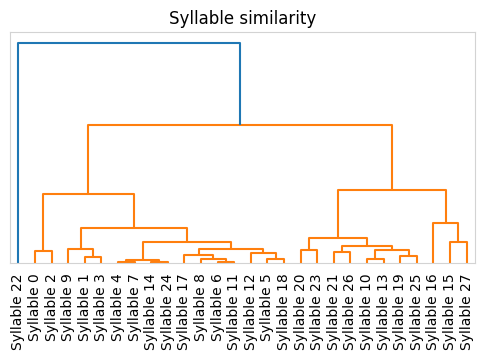

In [40]:
kpms.plot_similarity_dendrogram(
    coordinates, 
    results, 
    project_dir, 
    model_name, 
    min_frequency=0.005, 
    min_duration=3, 
    **config()
    )

### 3.4 Check syllable with manual labels.

In [63]:
import os
import pandas as pd
import numpy as np
kpms_ver_csv_path = "/home/gxj/Desktop/gxj/code/lst_3d_code/G1M1D1_cam1_labels.csv"
ver_df = pd.read_csv(kpms_ver_csv_path)
ver_df = ver_df.drop(columns=['Unnamed: 0', 'background', 'innest'])
bhvr_cols = ver_df.columns.tolist()
project_dir = "/home/gxj/Desktop/gxj/kpms_project"
labeled_frames = 8100
model_dirs = [d for d in os.listdir(project_dir) if d.startswith('kappa_scan_') and os.path.isdir(os.path.join(project_dir, d))]

metrics = []
for model_name in model_dirs:
    kpms_results_dir = f"{project_dir}/{model_name}/results"
    kpms_results_path = os.path.join(kpms_results_dir, '-home-gxj-Desktop-Synology25-dannce_results-exp_111-save_data_AVG0.csv')
    if not os.path.exists(kpms_results_path):
        print(f"Skip {model_name}: missing results file.")
        continue
    results_df = pd.read_csv(kpms_results_path)
    merged = pd.concat([results_df.iloc[:labeled_frames, :].reset_index(drop=True),
                        ver_df.iloc[:labeled_frames, :].reset_index(drop=True)], axis=1)

    if 'syllable' not in merged.columns:
        print(f"Skip {model_name}: no syllable column.")
        continue
    # p(behavior | syllable)
    crosstab_syl = merged.groupby('syllable')[bhvr_cols].mean()
    # p(syllable | behavior)
    unique_syllables = sorted(merged['syllable'].unique())
    crosstab_bhvr = pd.DataFrame(index=bhvr_cols, columns=unique_syllables, dtype=float)
    for b in bhvr_cols:
        subset = merged.loc[merged[b] == 1, 'syllable']
        if subset.empty:
            crosstab_bhvr.loc[b, :] = 0.0
            continue
        counts = subset.value_counts(normalize=True)
        crosstab_bhvr.loc[b, :] = [counts.get(s, 0.0) for s in unique_syllables]
    # Purity: Σ_s freq(s)*max_b p(b|s)
    syll_freq = merged['syllable'].value_counts(normalize=True)
    purity = sum(syll_freq.get(s, 0.0) * crosstab_syl.loc[s].max() for s in crosstab_syl.index)
    # Behavior Coverage: mean_b max_s p(s|b)
    coverage = crosstab_bhvr.max(axis=1).mean()
    metrics.append({'model': model_name, 'purity': purity, 'coverage': coverage})
metrics_df = pd.DataFrame(metrics).sort_values('purity', ascending=False)
print(metrics_df)
metrics_df.to_csv('G1M1D1_metrics.csv', index=False)
best_simple = metrics_df.iloc[0]['model'] if not metrics_df.empty else None
print(f"Best model by purity (simple): {best_simple}")


              model    purity  coverage
3  kappa_scan_1e+07  0.547407  0.491343
4  kappa_scan_1e+04  0.546543  0.378266
1  kappa_scan_1e+03  0.541111  0.348939
0  kappa_scan_1e+06  0.538148  0.514077
2  kappa_scan_1e+05  0.532099  0.436806
5  kappa_scan_1e+08  0.524568  0.517087
Best model by purity (simple): kappa_scan_1e+07


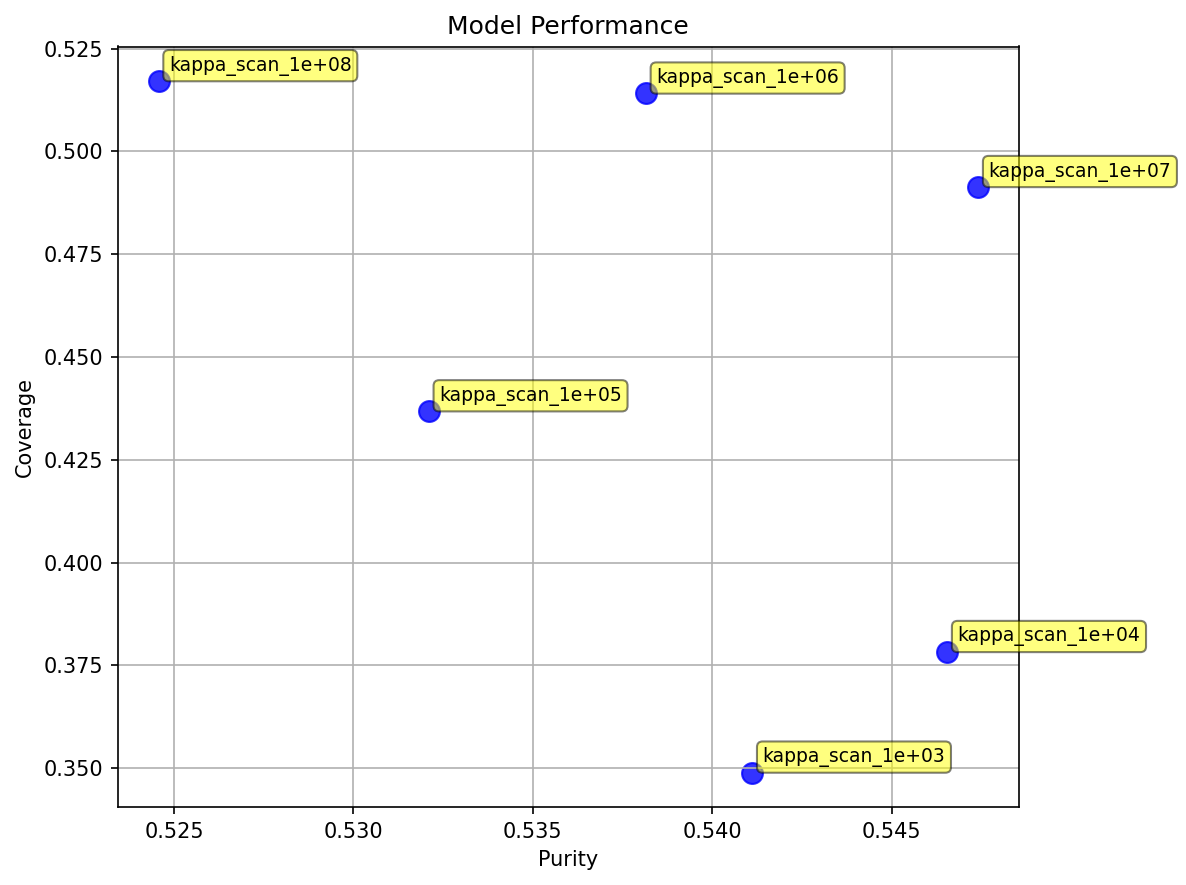

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot: Purity vs Coverage
fig, ax = plt.subplots(figsize=(8, 6), dpi=150)
scatter = ax.scatter(metrics_df['purity'], metrics_df['coverage'], 
                     s=100, c='blue', alpha=0.8)
for i, model in enumerate(metrics_df['model']):
    ax.annotate(model, 
                (metrics_df.iloc[i]['purity'], metrics_df.iloc[i]['coverage']),
                xytext=(5, 5), textcoords='offset points', fontsize=9,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.5))
ax.set_xlabel('Purity')
ax.set_ylabel('Coverage')
ax.set_title('Model Performance')
ax.grid(True)
plt.tight_layout()
plt.savefig('G1M1D1_metrics.png', dpi=300, bbox_inches='tight')
plt.show()


In [66]:
import os
import numpy as np
import pandas as pd
kpms_ver_csv_path = "/home/gxj/Desktop/gxj/code/lst_3d_code/G1M1D1_cam1_labels.csv"
ver_df = pd.read_csv(kpms_ver_csv_path)
ver_df = ver_df.drop(columns=['Unnamed: 0', 'background', 'innest'])
project_dir = "/home/gxj/Desktop/gxj/kpms_project"
model_name = "kappa_scan_1e+07"
kpms_results_dir = f"{project_dir}/{model_name}/results"
kpms_results_path = os.path.join(kpms_results_dir, '-home-gxj-Desktop-Synology25-dannce_results-exp_111-save_data_AVG0.csv')
results_df = pd.read_csv(kpms_results_path)
labeled_frames = 8100
# Merge model syllables with manual labels (limit to first 8100 frames for this example)
df = pd.concat([
    results_df.iloc[:labeled_frames, :].reset_index(drop=True),
    ver_df.iloc[:labeled_frames, :].reset_index(drop=True)
], axis=1)

# =============================
# 1) p(behavior | syllable)
# Rows: syllable, Cols: behavior
# =============================
bhvr_cols = ver_df.columns.tolist()
crosstab_syl = pd.DataFrame()
for b in bhvr_cols:
    # Mean of the binary column within each syllable gives p(b | syllable)
    crosstab_syl[b] = df.groupby("syllable")[b].mean()
# Optional residual mass if manual labels do not exhaust all possibilities
crosstab_syl['others'] = (1 - crosstab_syl.sum(axis=1)).clip(lower=0)
crosstab_syl.to_csv("G1M1D1_crosstab_syl.csv", index=True)

# =============================
# 2) p(syllable | behavior)
# Rows: behavior, Cols: syllable (FLIPPED ORIENTATION)
# =============================
unique_syllables = sorted(df['syllable'].unique())

# Initialize DataFrame with behaviors as index and syllables as columns
crosstab_bhvr = pd.DataFrame(index=bhvr_cols, columns=unique_syllables, dtype=float)
for b in bhvr_cols:
    subset = df.loc[df[b] == 1, 'syllable']  # frames where behavior b is present
    if subset.empty:
        crosstab_bhvr.loc[b, :] = 0.0  # no occurrence of this behavior
        continue
    counts = subset.value_counts(normalize=True)  # p(syllable | b)
    crosstab_bhvr.loc[b, :] = [counts.get(s, 0.0) for s in unique_syllables]
crosstab_bhvr.to_csv('G1M1D1_crosstab_bhvr.csv', index_label='behavior')

# (Not adding an 'others' column here because each row already sums to 1; if multi-label rows exist that reduce total mass you can uncomment below)
# crosstab_bhvr['others'] = (1 - crosstab_bhvr.sum(axis=1)).clip(lower=0)

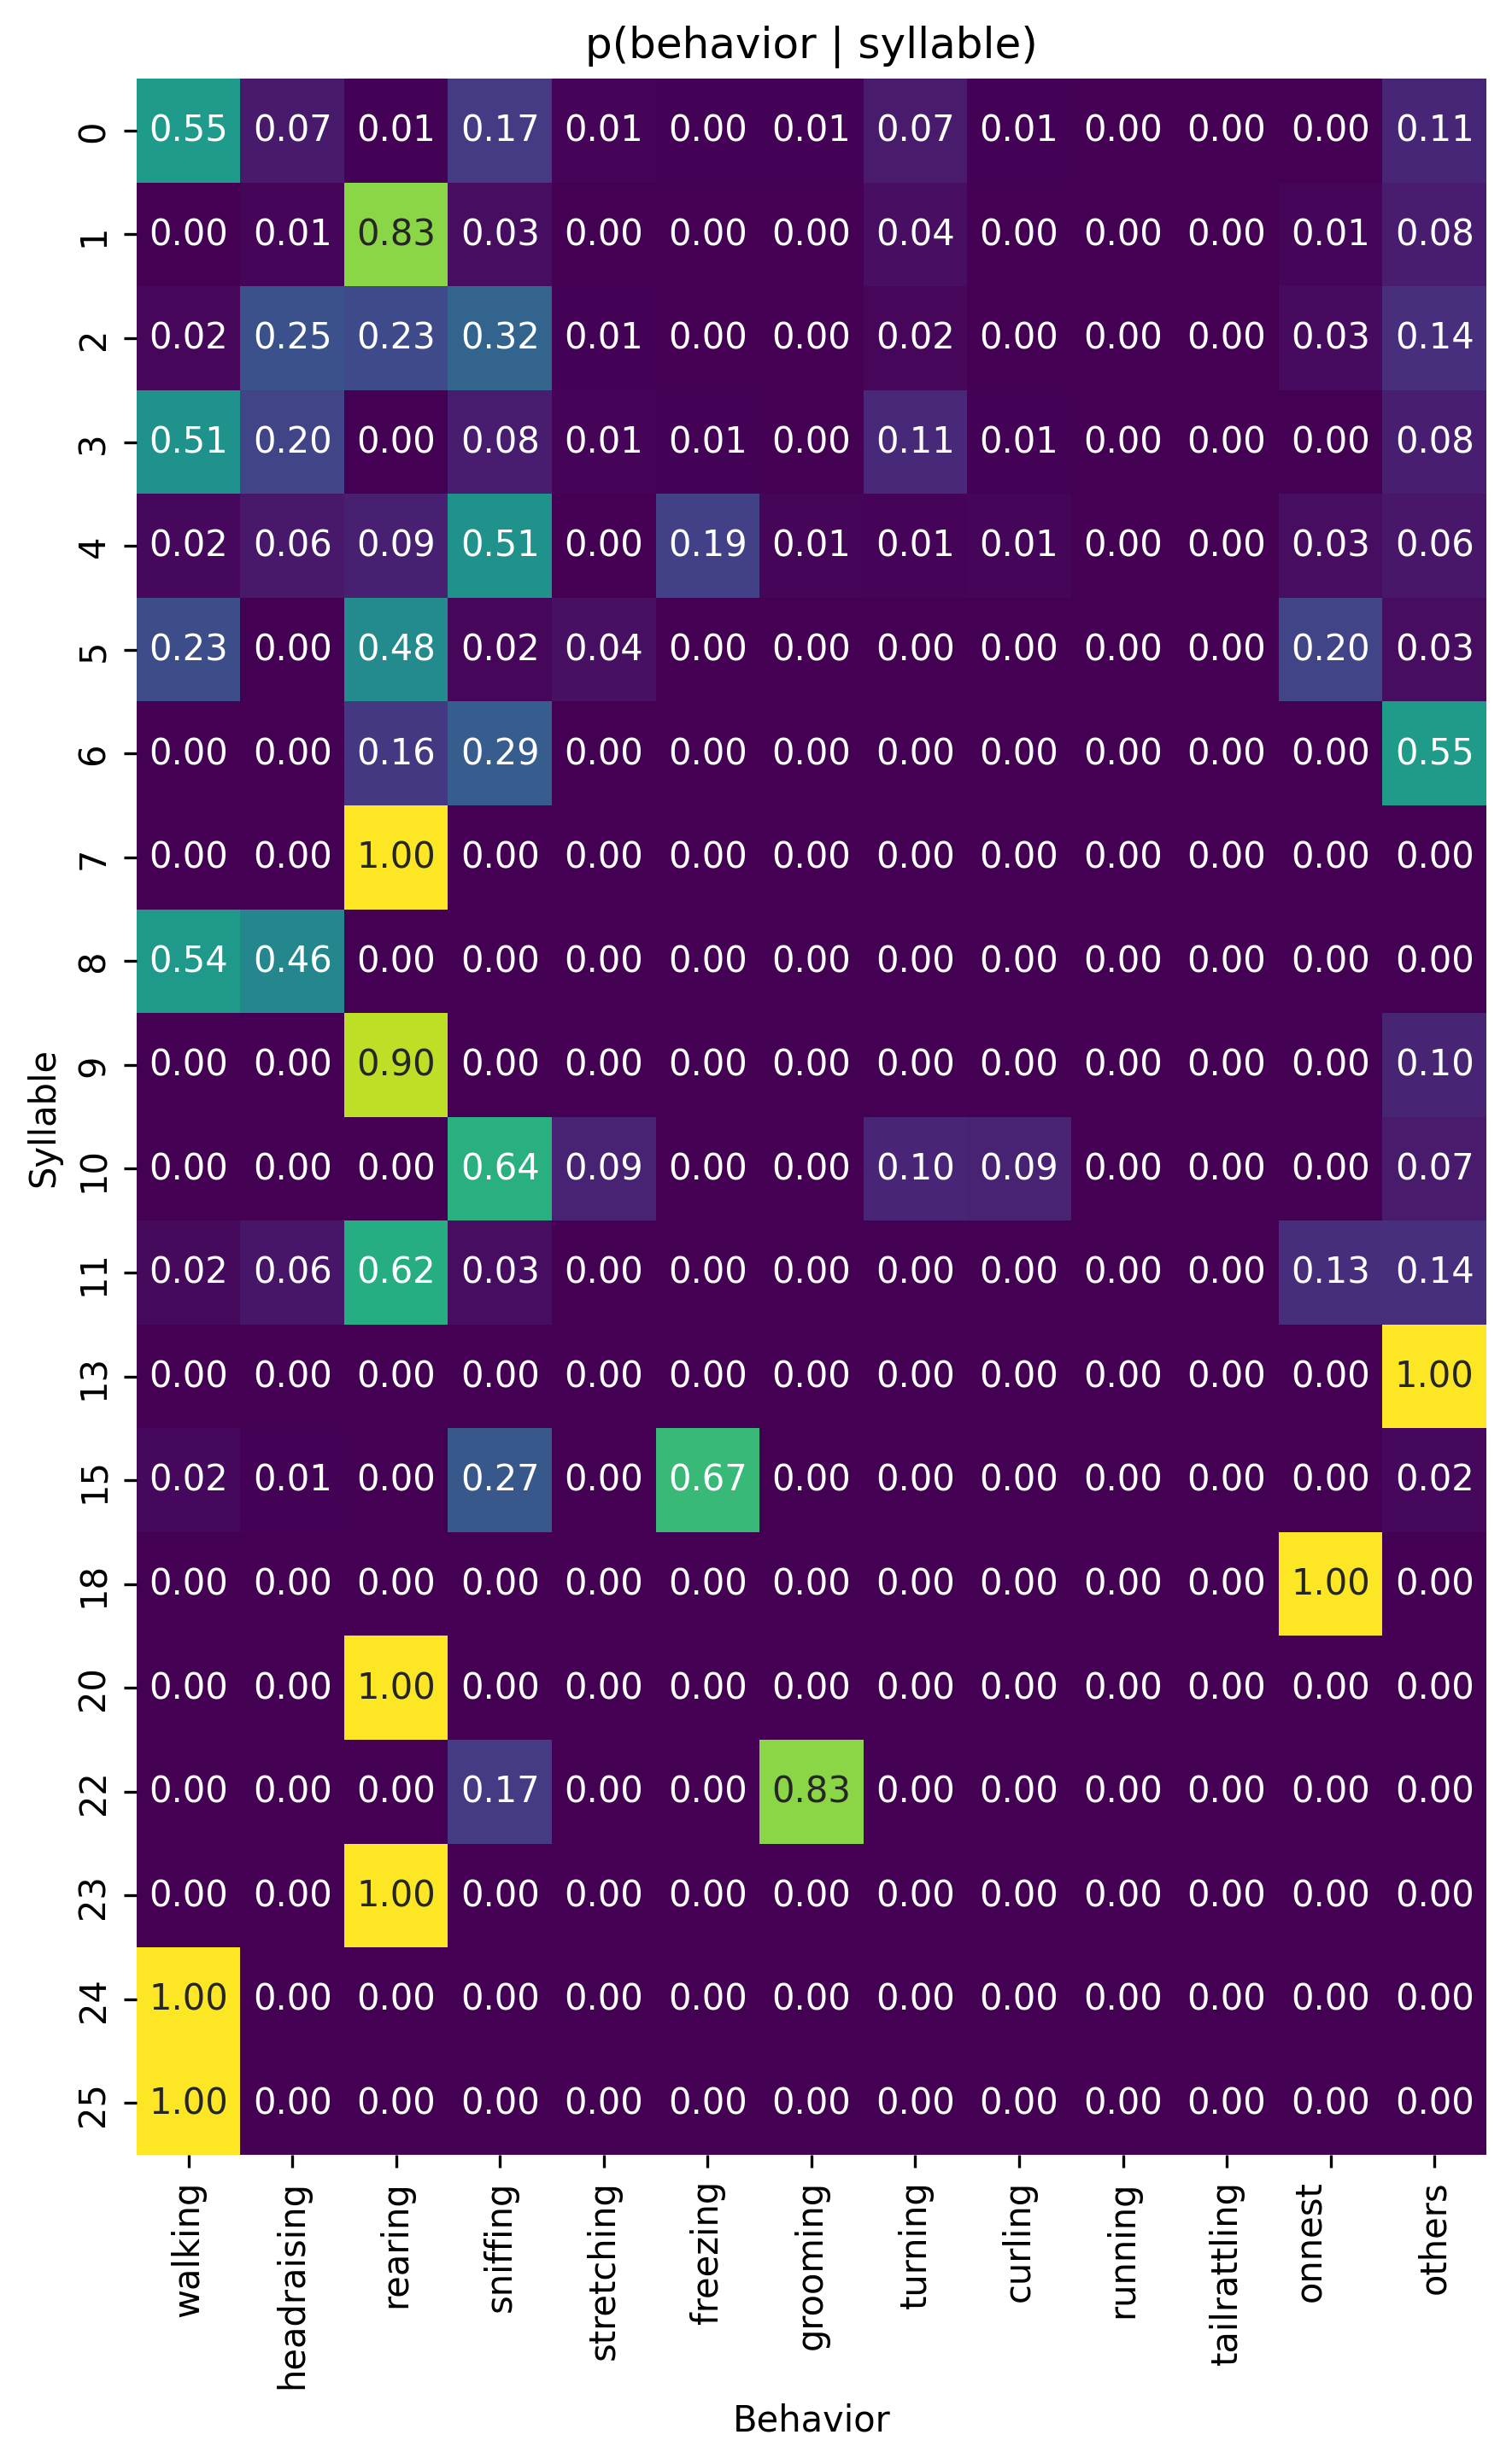

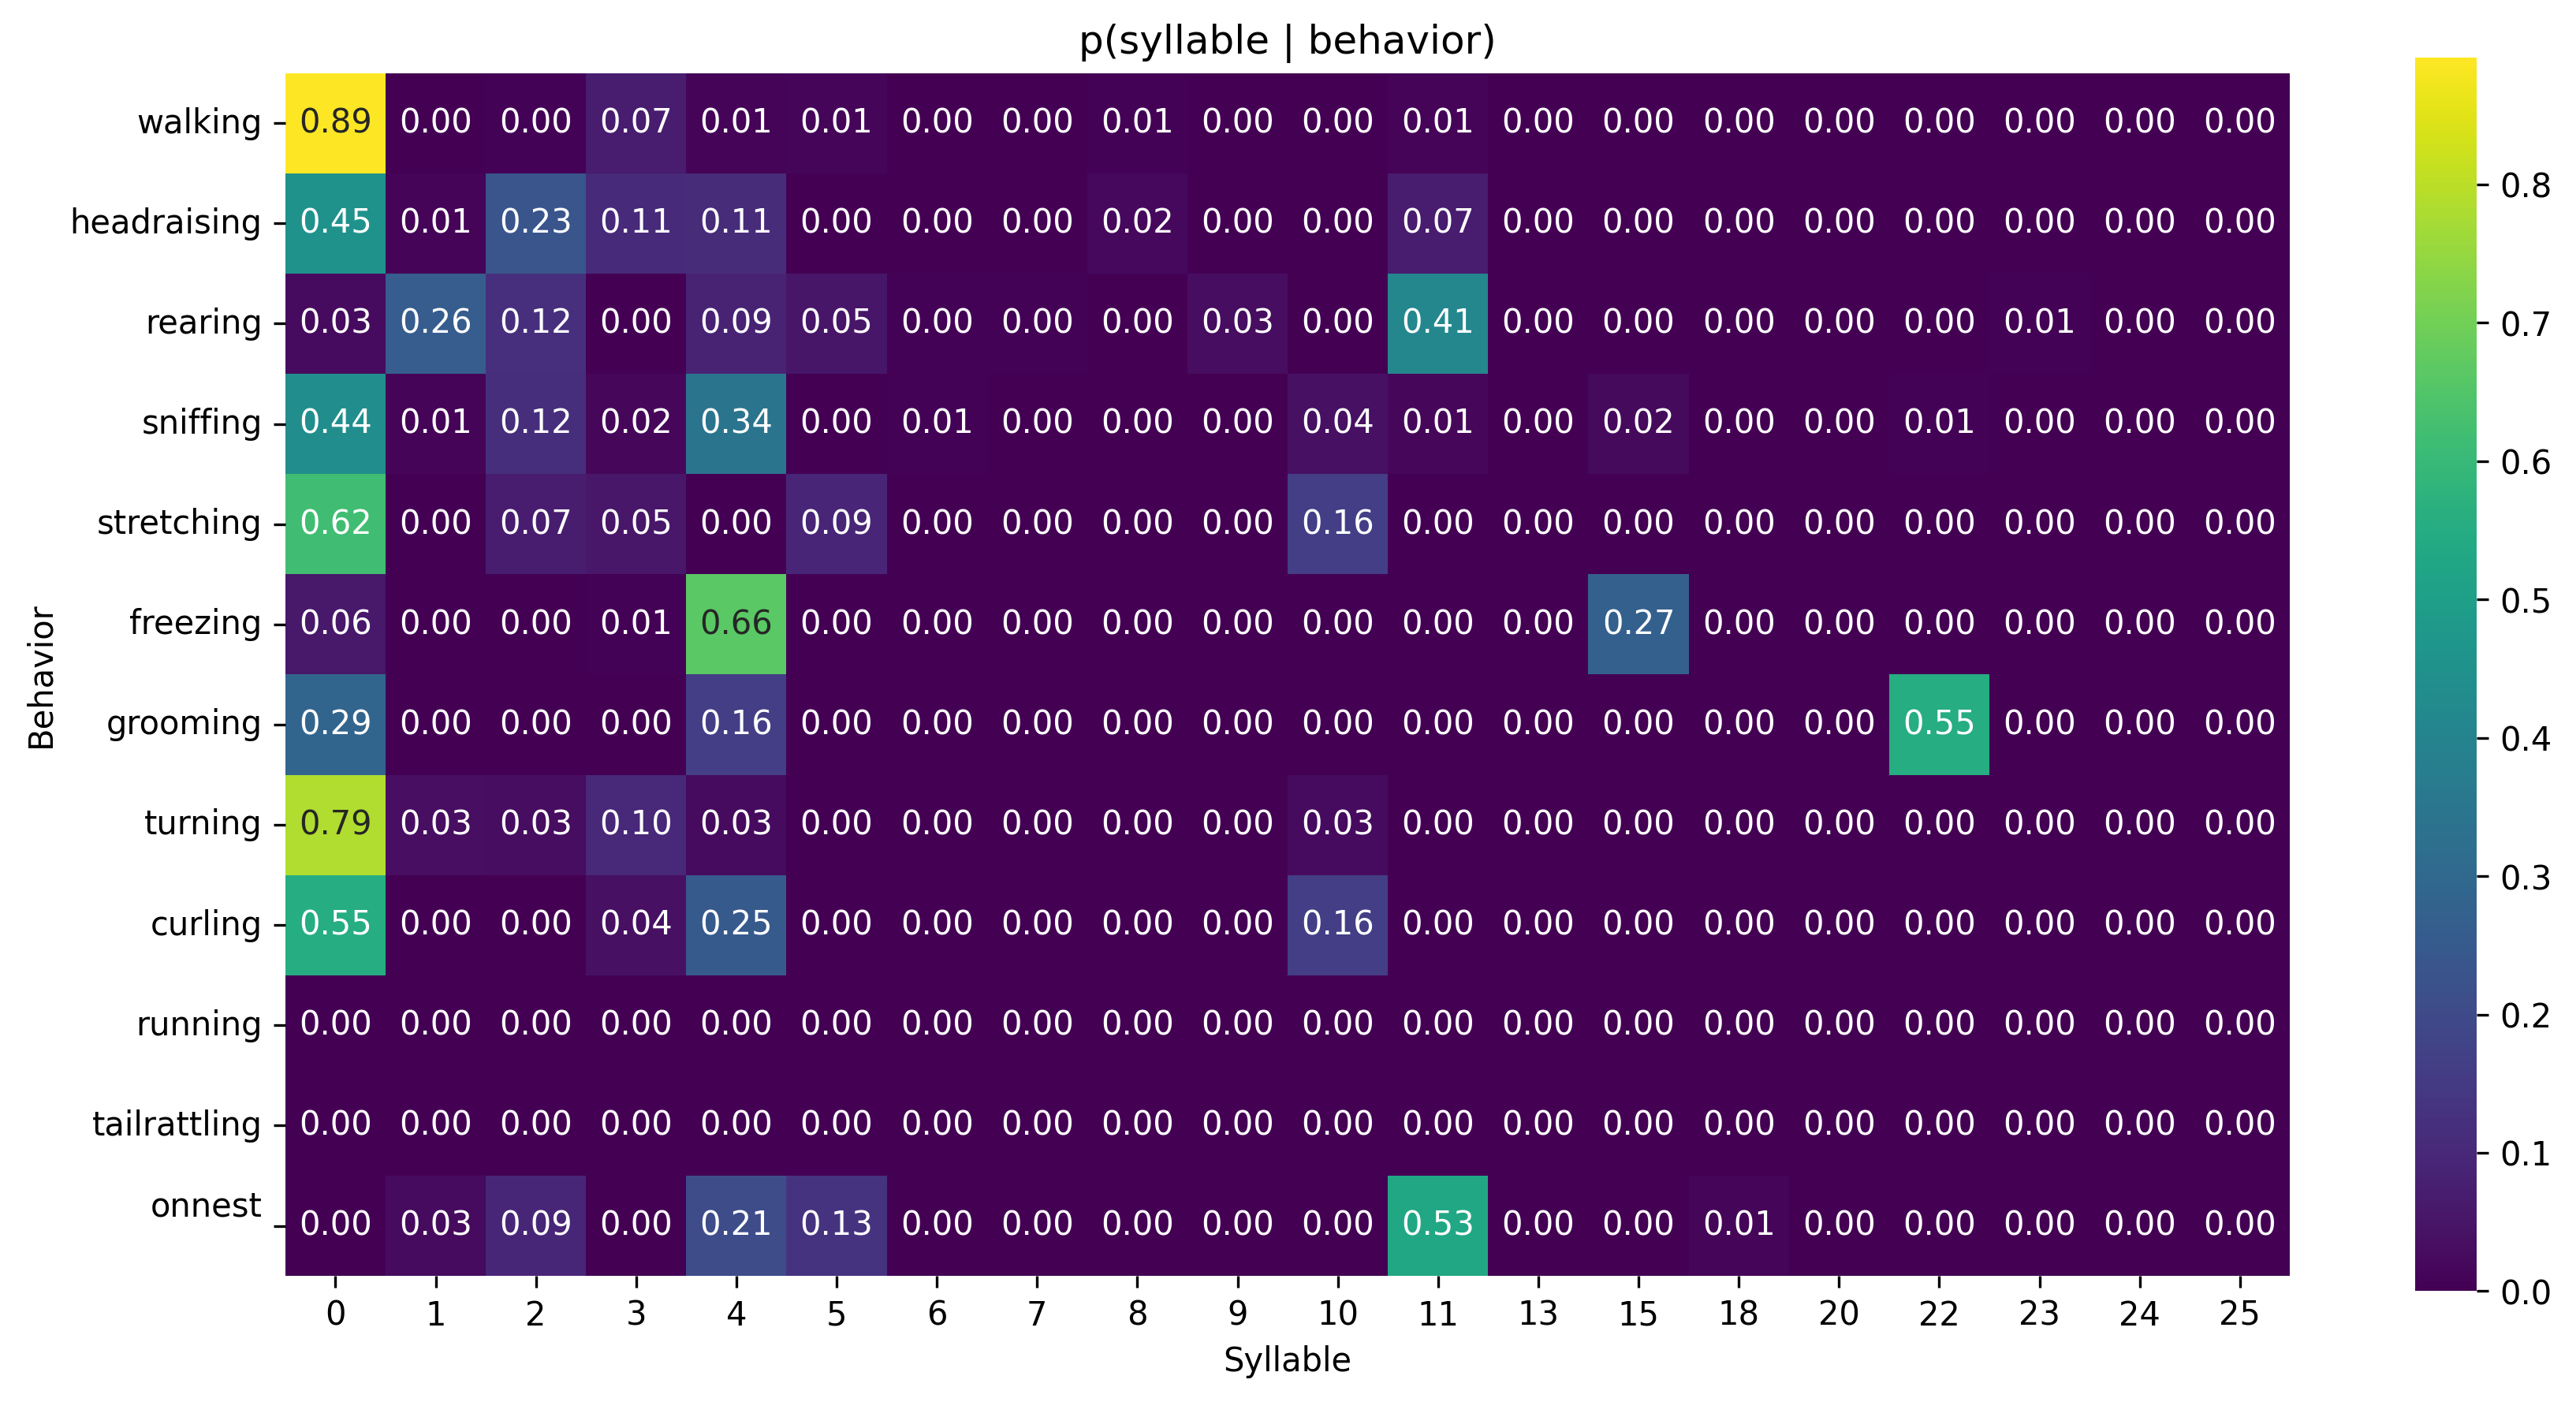

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(dpi=300, figsize=(6, 12))
sns.heatmap(
    crosstab_syl,
    annot=True,
    fmt=".2f",
    cmap="viridis",
    cbar=False,
    square=True,
)
plt.title("p(behavior | syllable)")
plt.ylabel("Syllable")
plt.xlabel("Behavior")
plt.tight_layout()
plt.savefig('G1M1D1_crosstab_syl.png', dpi=300, bbox_inches='tight')
plt.show()

plt.figure(dpi=300, figsize=(12, 6))
sns.heatmap(
    crosstab_bhvr,
    annot=True,
    fmt=".2f",
    cmap="viridis",
    square=True,
)
plt.title("p(syllable | behavior)")
plt.ylabel("Behavior")
plt.xlabel("Syllable")
plt.tight_layout()
plt.savefig('G1M1D1_crosstab_bhvr.png', dpi=300, bbox_inches='tight')
plt.show()